### Santander Customer Transaction Prediction

[Kaggle Dataset](https://www.kaggle.com/c/santander-customer-transaction-prediction/overview)

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
import lightgbm as lgb
import xgboost as xgb
import pickle
import requests
import json
import os
import warnings
import mlflow
warnings.filterwarnings('ignore')

In [18]:
url_train = 'https://drive.google.com/file/d/1ndNO8Rb-8QHF0193m2r7OlLFWhDIDvh7/view?usp=drive_link'
train_data = pd.read_csv('https://drive.usercontent.google.com/download?id={}&export=download&authuser=0&confirm=t'.format(url_train.split('/')[-2]))


In [19]:
train_data.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [20]:
url_test = 'https://drive.google.com/file/d/1qiUzEUC3UihxGUUG_2K_v0CLlyjmrtZF/view?usp=drive_link'
test_data = pd.read_csv('https://drive.usercontent.google.com/download?id={}&export=download&authuser=0&confirm=t'.format(url_train.split('/')[-2]))


In [21]:
test_data.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [16]:
train_data.shape

(200000, 202)

In [17]:
test_data.shape

(200000, 201)

### Procedures:
---
- Exploratory Data Analysis
- Feature Engineering/Selection
- Build Model
- Evaluate Perfomance
- Generate Pickle and Export Model

In [18]:
train_data.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [19]:
test_data.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [20]:
print('Number of Training = {}'.format(train_data.shape[0]))
print('Number of Test = {}\n'.format(test_data.shape[0]))

#target columns
train_data.columns

Number of Training = 200000
Number of Test = 200000



Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

In [21]:
test_data.columns

Index(['ID_code', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5',
       'var_6', 'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)

#### Checking for missing data
---

In [22]:
pd.isnull(train_data).sum()

ID_code    0
target     0
var_0      0
var_1      0
var_2      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 202, dtype: int64

In [23]:
#Check for the missing values: 
pd.isnull(test_data).sum()

ID_code    0
var_0      0
var_1      0
var_2      0
var_3      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 201, dtype: int64

In [24]:
train_data.describe(include="all")

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
unique,200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,train_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,NaN,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,NaN,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,NaN,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,NaN,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,NaN,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800


In [25]:
test_data.describe(include="all")

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
unique,200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,test_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,NaN,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,NaN,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,NaN,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,NaN,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,NaN,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400


#### Data Visualization
---

From the previous analysis above and the description of the data, we can conclude that:
- All features have numerical values;
- We don't have missing values;
- Our prediction is a binary prediction;
- All values are unique;
- The train dataset is unbalanced


In [26]:
def plotting_feature_distribution(df1, df2, lb1, lb2, features):
    
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(24,14))

    count = 0
    for feature in features:
        count = count + 1
        
        plt.subplot(3,6,count)
        
        sns.kdeplot(data=df1[feature], bw=1 ,cut=3, palette="crest", label=lb1)
        sns.kdeplot(data=df2[feature], bw=1, cut=3, palette="crest", label=lb2)
        #bw_adjust=3, cut=3, fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0)
        locs, labels = plt.xticks()
        
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
        plt.legend()

<Figure size 640x480 with 0 Axes>

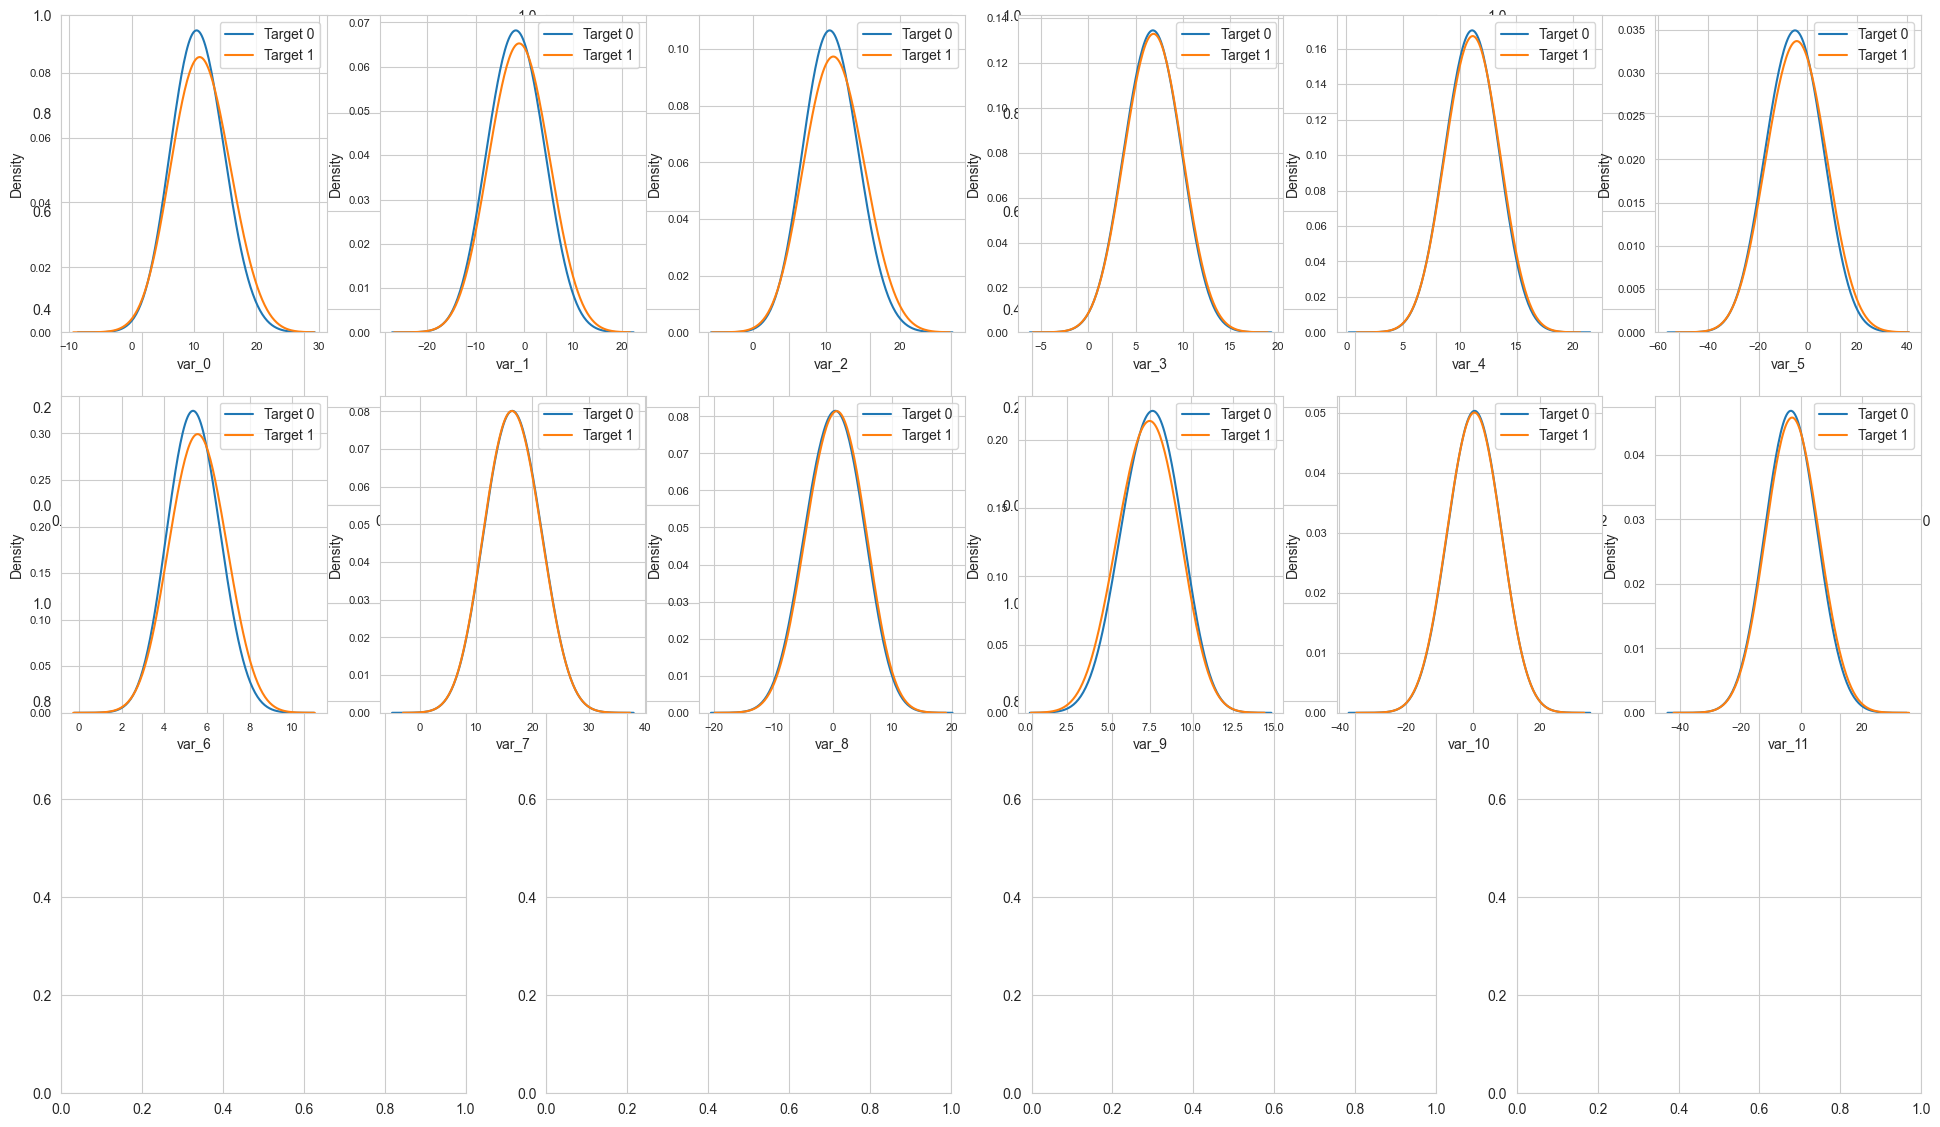

In [27]:
target0 = train_data.loc[train_data['target'] == 0]
target1 = train_data.loc[train_data['target'] == 1]

features = train_data.columns.values[2:14]
plotting_feature_distribution(target0, target1, "Target 0", "Target 1", features)

<Figure size 640x480 with 0 Axes>

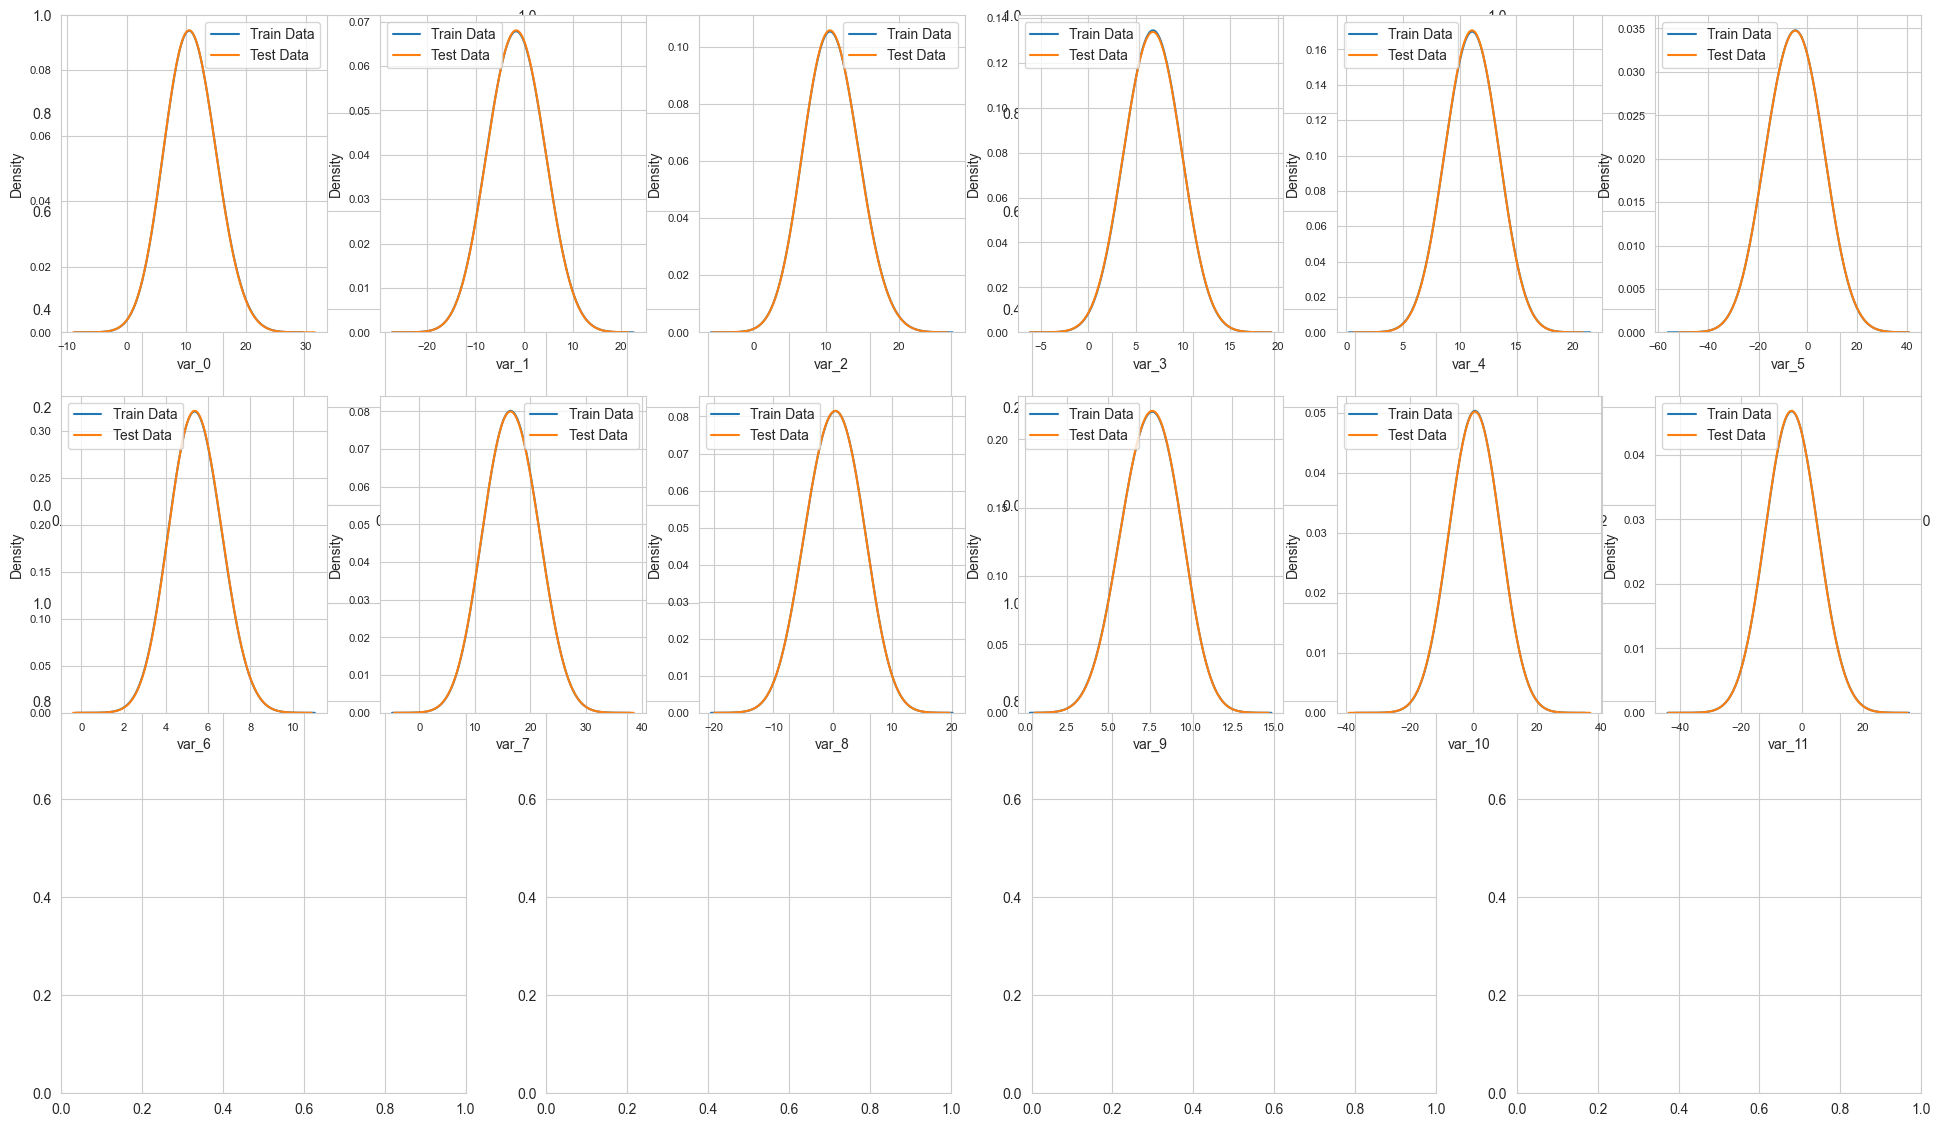

In [28]:
#The first 12 features distribuitions, density of each dataset
features = train_data.columns.values[2:14]
plotting_feature_distribution(train_data, test_data, "Train Data", "Test Data", features)

For each feature, we can see a very short difference between the density of the features when the target is 0 or 1. Looking at the training and test data, they have a very close density. As the data is anonymous and we don't know much about each feature, we can conclude that this dataset had a good pre-processing of the data, but not necessarily that they have been normalized.

**Visualization of the distribution of maximum and minimum values, per column in the test and training data.**

In [29]:
def plotting_max_distribution(df1, df2, features):

    plt.figure(figsize=(24,14))

    plt.title("Distribution of the Max Values in Train and Test data (COLUMN)")
    sns.distplot(df1[features].max(axis=0), color="blue", kde=True, bins=120, label="Train Data")
    sns.distplot(df2[features].max(axis=0), color="green", kde=True, bins=120, label="Test Data")
    plt.legend(fontsize='x-large', title_fontsize='25')
    
def plotting_min_distribution(df1, df2, features):

    plt.figure(figsize=(24,14))

    plt.title("Distribution of the Min Values in Train and Test data (COLUMN)")
    sns.distplot(df1[features].min(axis=0), color="blue", kde=True, bins=120, label="Train Data")
    sns.distplot(df2[features].min(axis=0), color="green", kde=True, bins=120, label="Test Data")
    plt.legend(fontsize='x-large', title_fontsize='25')
    
def plotting_mean_distribution(df1, df2, features):

    plt.figure(figsize=(24,14))

    plt.title("Distribution of the Mean Values in Train and Test data (COLUMN)")
    sns.distplot(df1[features].mean(axis=0), color="blue", kde=True, bins=120, label="Train Data")
    sns.distplot(df2[features].mean(axis=0), color="green", kde=True, bins=120, label="Test Data")
    plt.legend(fontsize='x-large',  title_fontsize='25')
    
def plotting_std_distribution(df1, df2, features):
    
    plt.figure(figsize=(24,14))

    plt.title("Distribution of the Standard deviation in Train and Test data (COLUMN)")
    sns.distplot(df1[features].std(axis=0), color="blue", kde=True, bins=120, label="Train Data")
    sns.distplot(df2[features].std(axis=0), color="green", kde=True, bins=120, label="Test Data")
    plt.legend(fontsize='x-large', title_fontsize='25')

**Visualization of the distribution of maximum and minimum values, per column in the test and training data.**

In [30]:
def plotting_max_row_distribution(df1, df2, features):

    plt.figure(figsize=(24,14))

    plt.title("Distribution of the Max Values in Train and Test data (ROW)")
    sns.distplot(df1[features].max(axis=1), color="blue", kde=True, bins=120, label="Train Data")
    sns.distplot(df2[features].max(axis=1), color="green", kde=True, bins=120, label="Test Data")
    plt.legend(fontsize='x-large', title_fontsize='25')
    
def plotting_min_row_distribution(df1, df2, features):

    plt.figure(figsize=(24,14))

    plt.title("Distribution of the Min Values in Train and Test data (ROW)")
    sns.distplot(df1[features].min(axis=1), color="blue", kde=True, bins=120, label="Train Data")
    sns.distplot(df2[features].min(axis=1), color="green", kde=True, bins=120, label="Test Data")
    plt.legend(fontsize='x-large', title_fontsize='25')
    
def plotting_mean_row_distribution(df1, df2, features):

    plt.figure(figsize=(24,14))

    plt.title("Distribution of the Mean Values in Train and Test data (ROW)")
    sns.distplot(df1[features].mean(axis=1), color="blue", kde=True, bins=120, label="Train Data")
    sns.distplot(df2[features].mean(axis=1), color="green", kde=True, bins=120, label="Test Data")
    plt.legend(fontsize='x-large', title_fontsize='25')
    
def plotting_std_row_distribution(df1, df2, features):

    plt.figure(figsize=(24,14))

    plt.title("Distribution of the Standard deviation in Train and Test data (ROW)")
    sns.distplot(df1[features].std(axis=1), color="blue", kde=True, bins=120, label="Train Data")
    sns.distplot(df2[features].std(axis=1), color="green", kde=True, bins=120, label="Test Data")
    plt.legend(fontsize='x-large', title_fontsize='25')

In [31]:
features = train_data.columns.values[2:200]

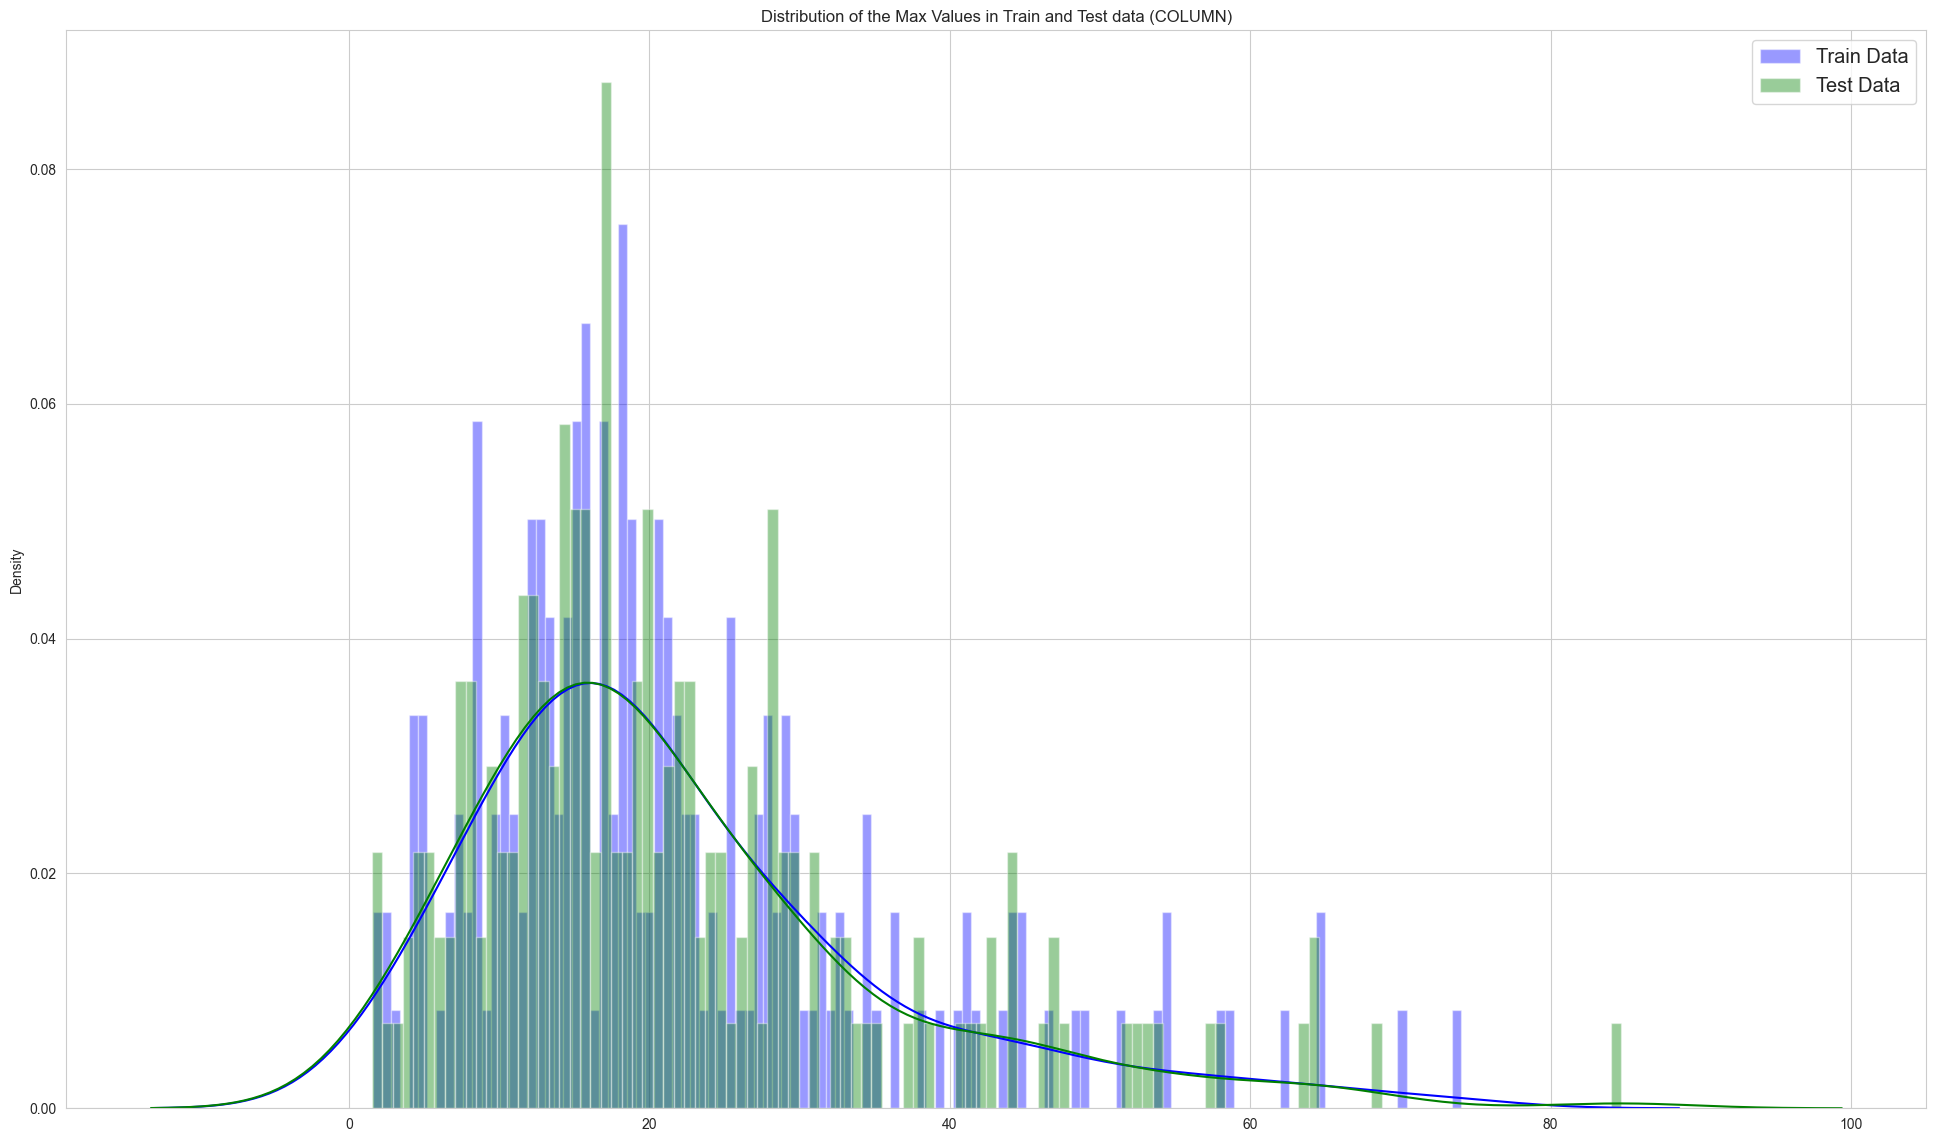

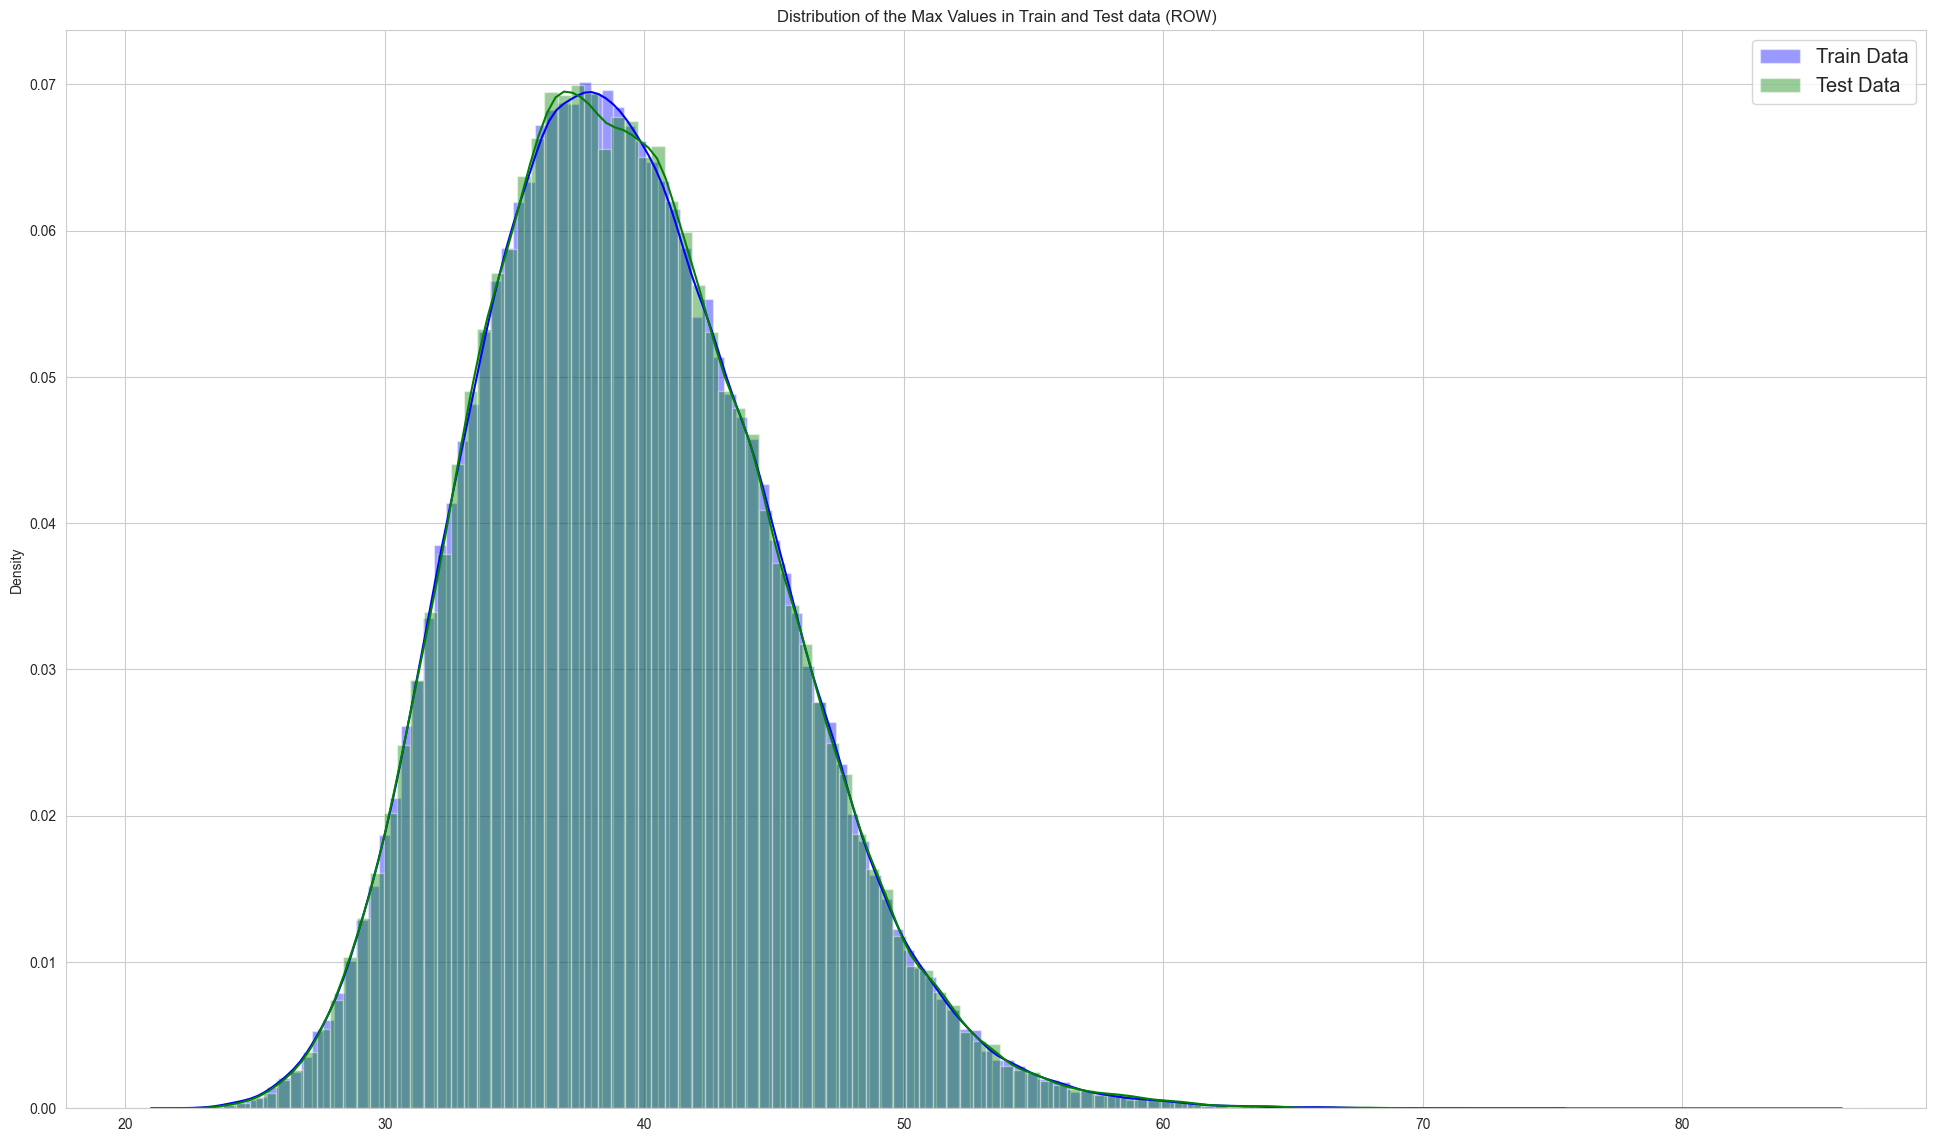

In [32]:
plotting_max_distribution(train_data, test_data, features)
plotting_max_row_distribution(train_data, test_data, features)

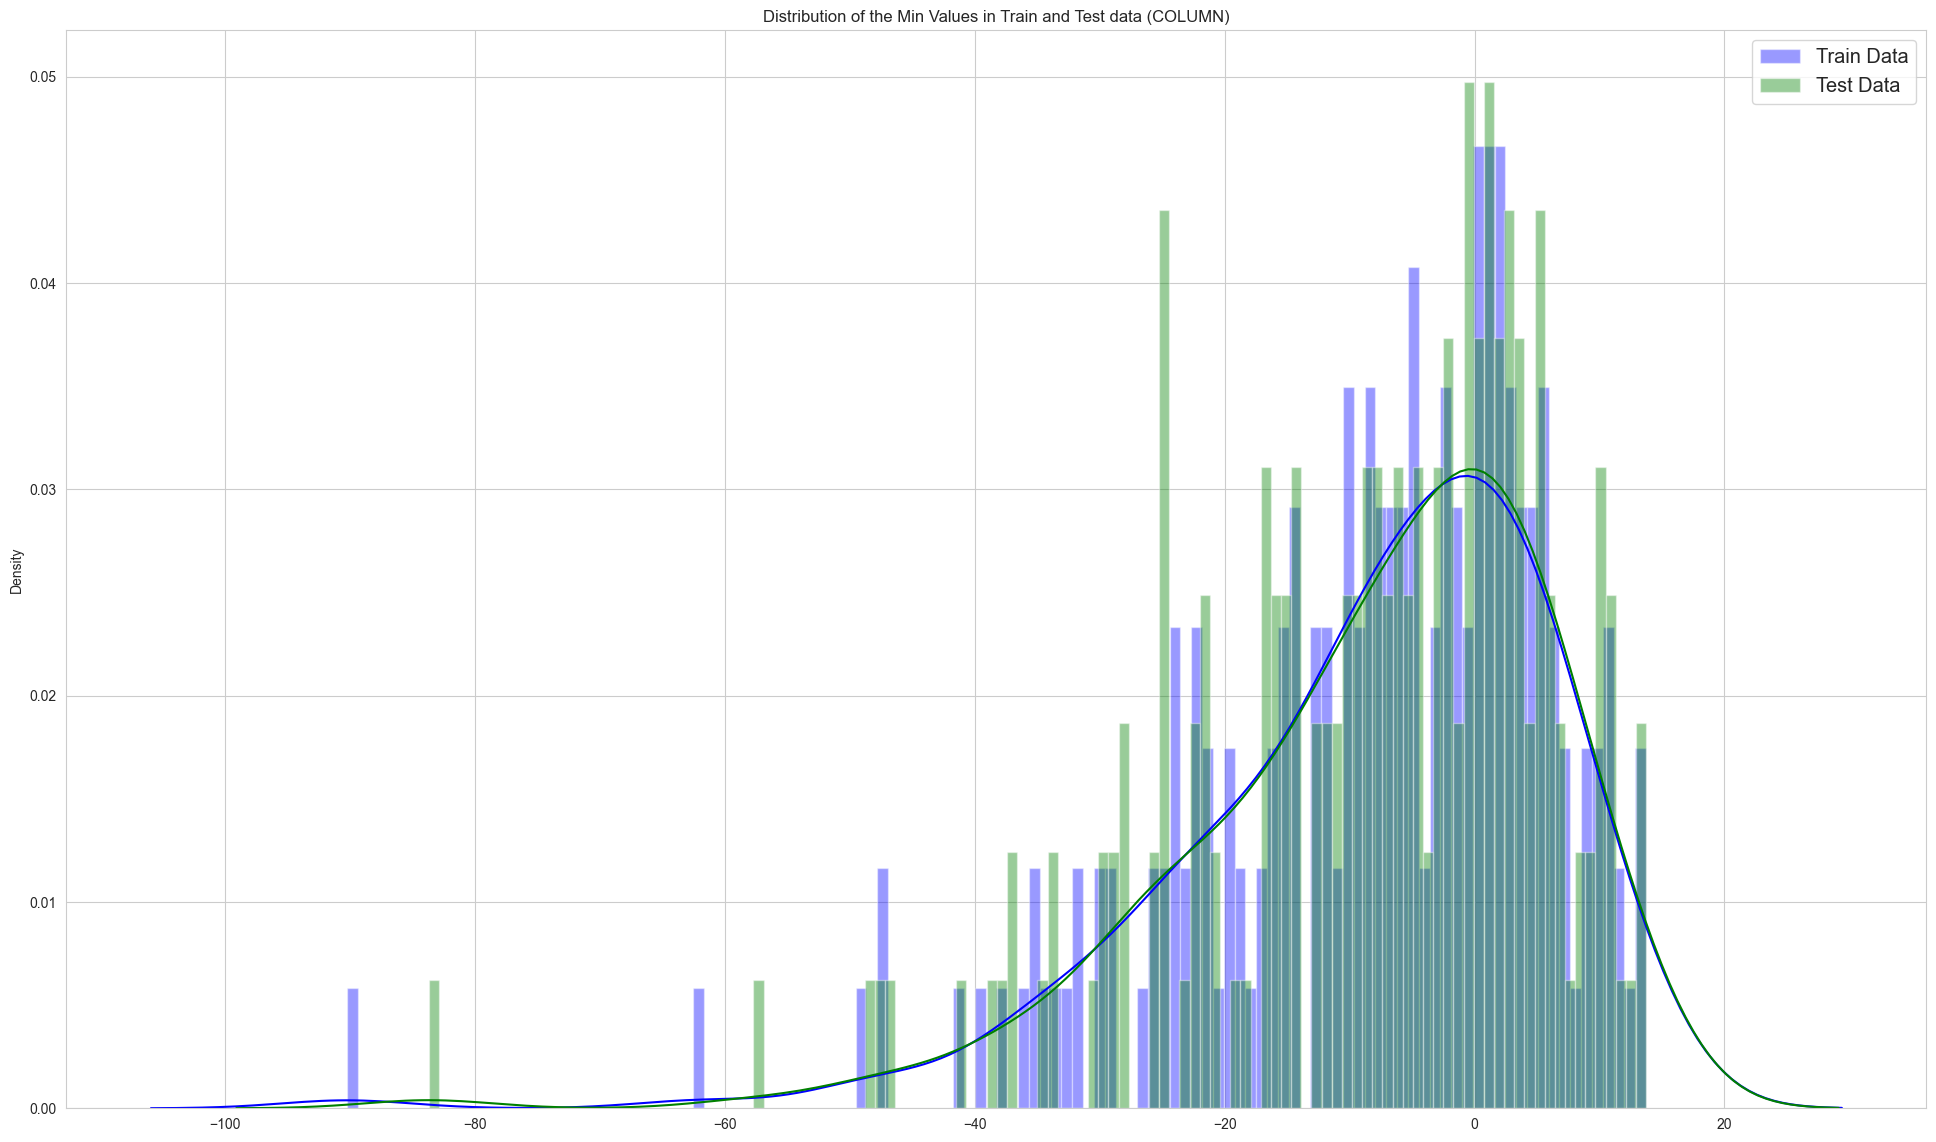

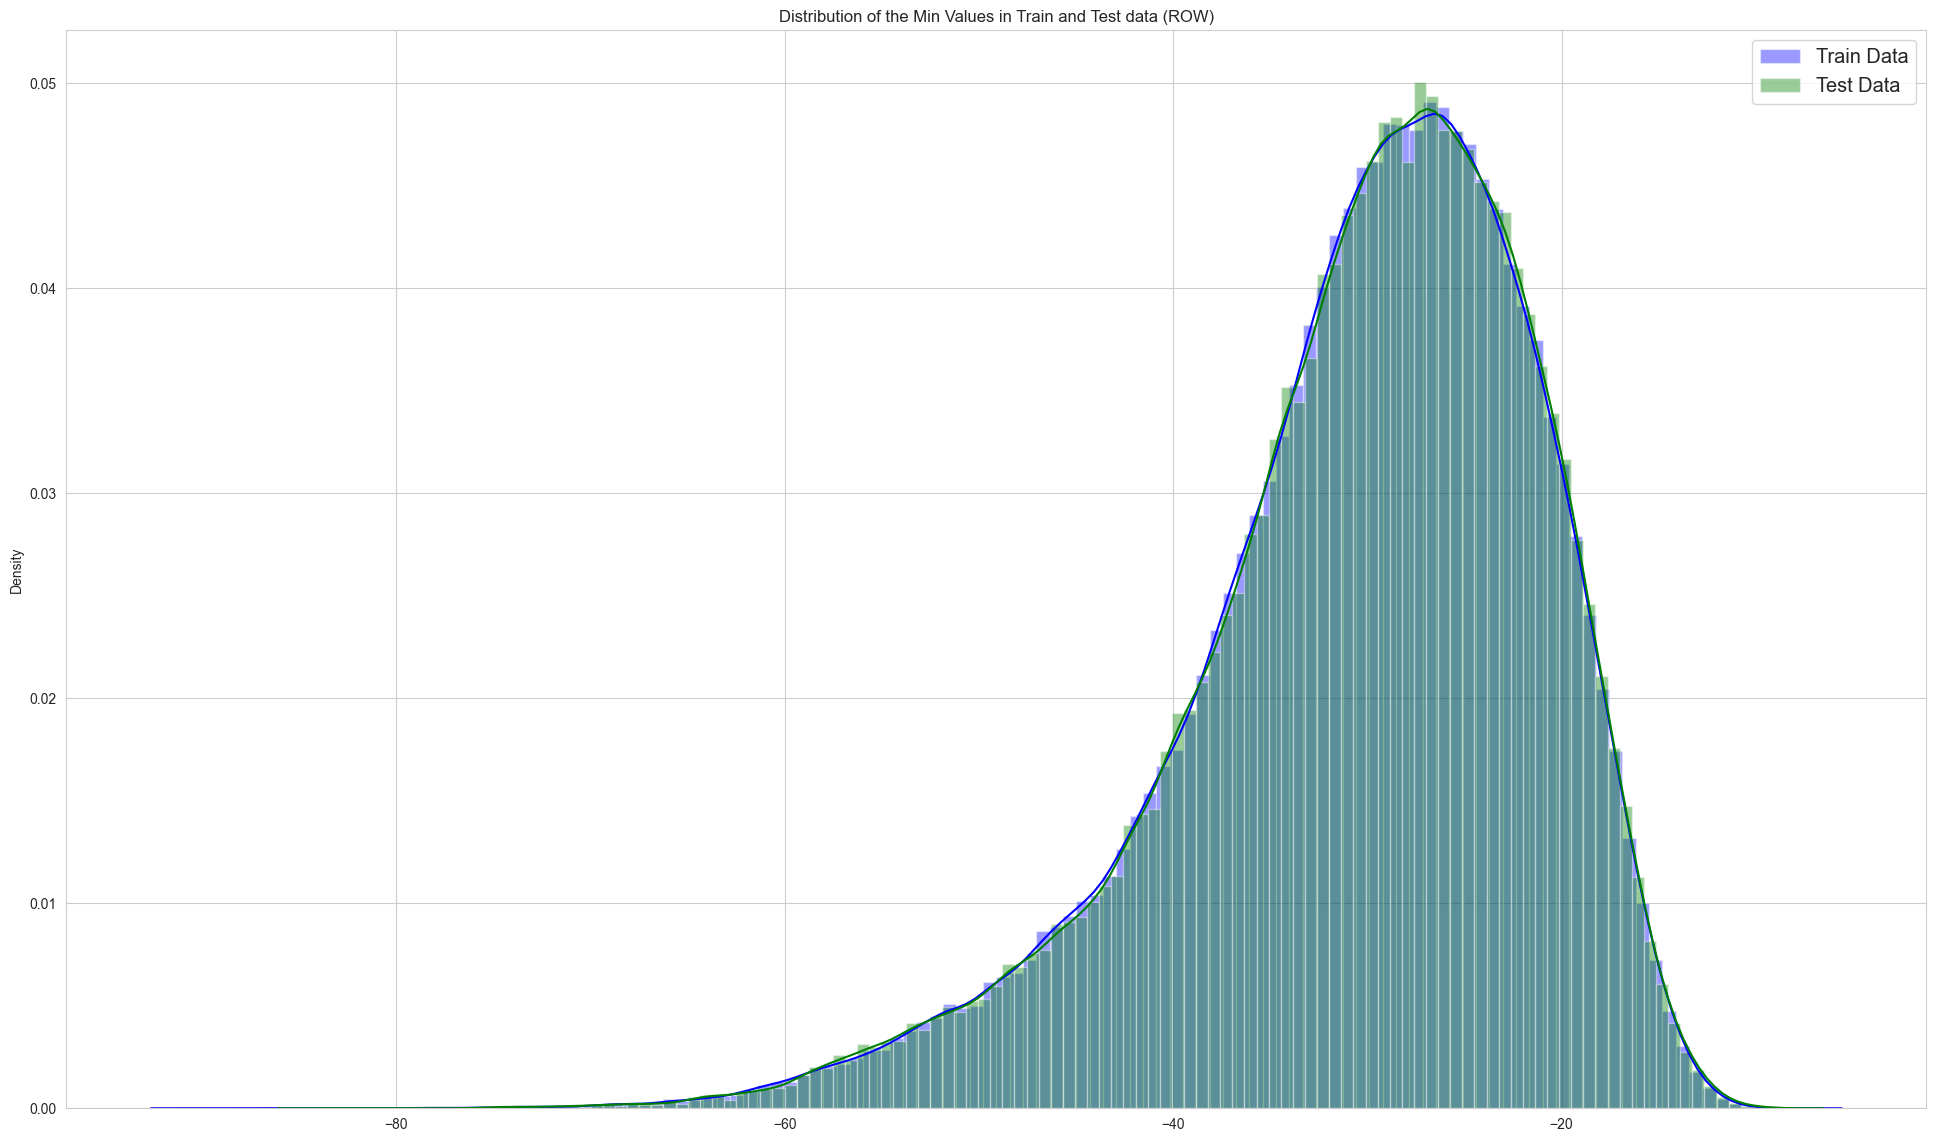

In [33]:
plotting_min_distribution(train_data, test_data, features)
plotting_min_row_distribution(train_data, test_data, features)

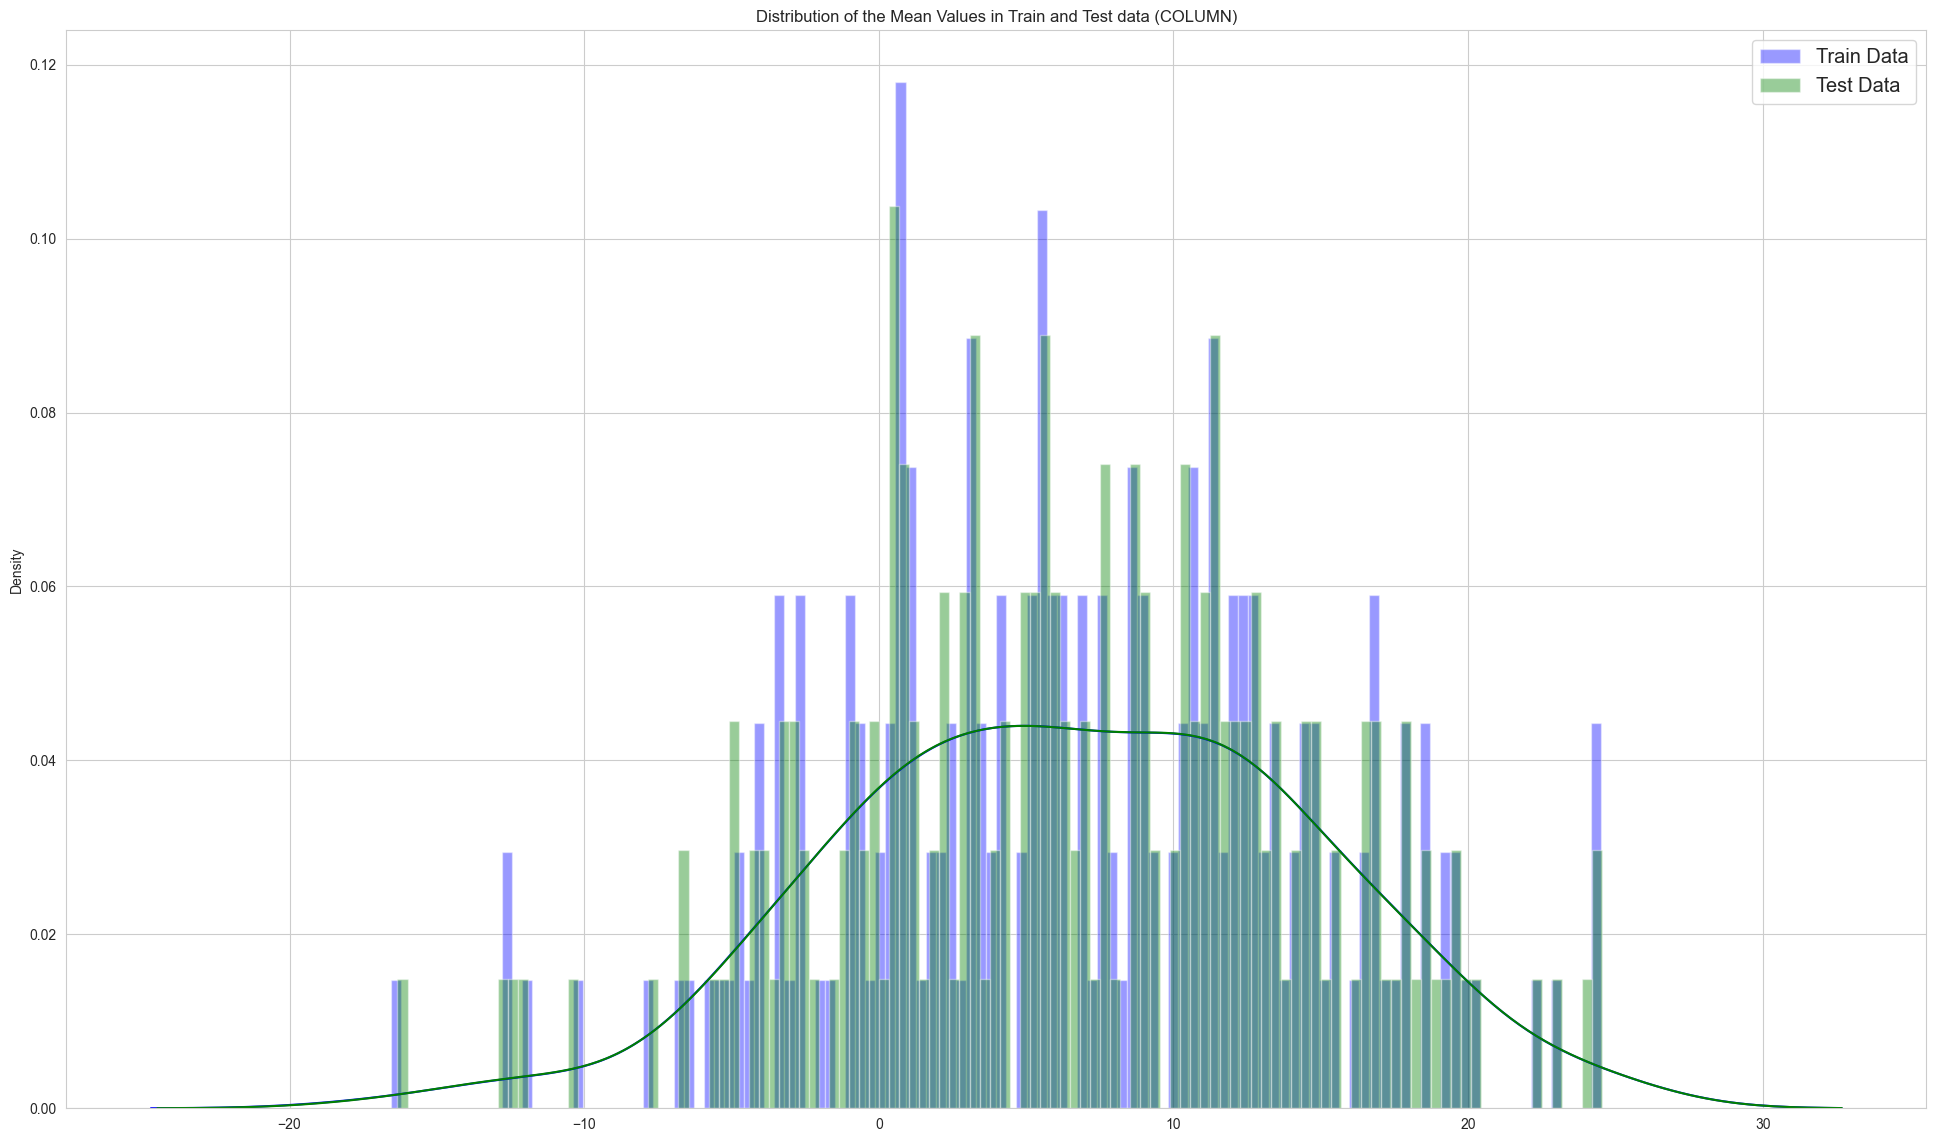

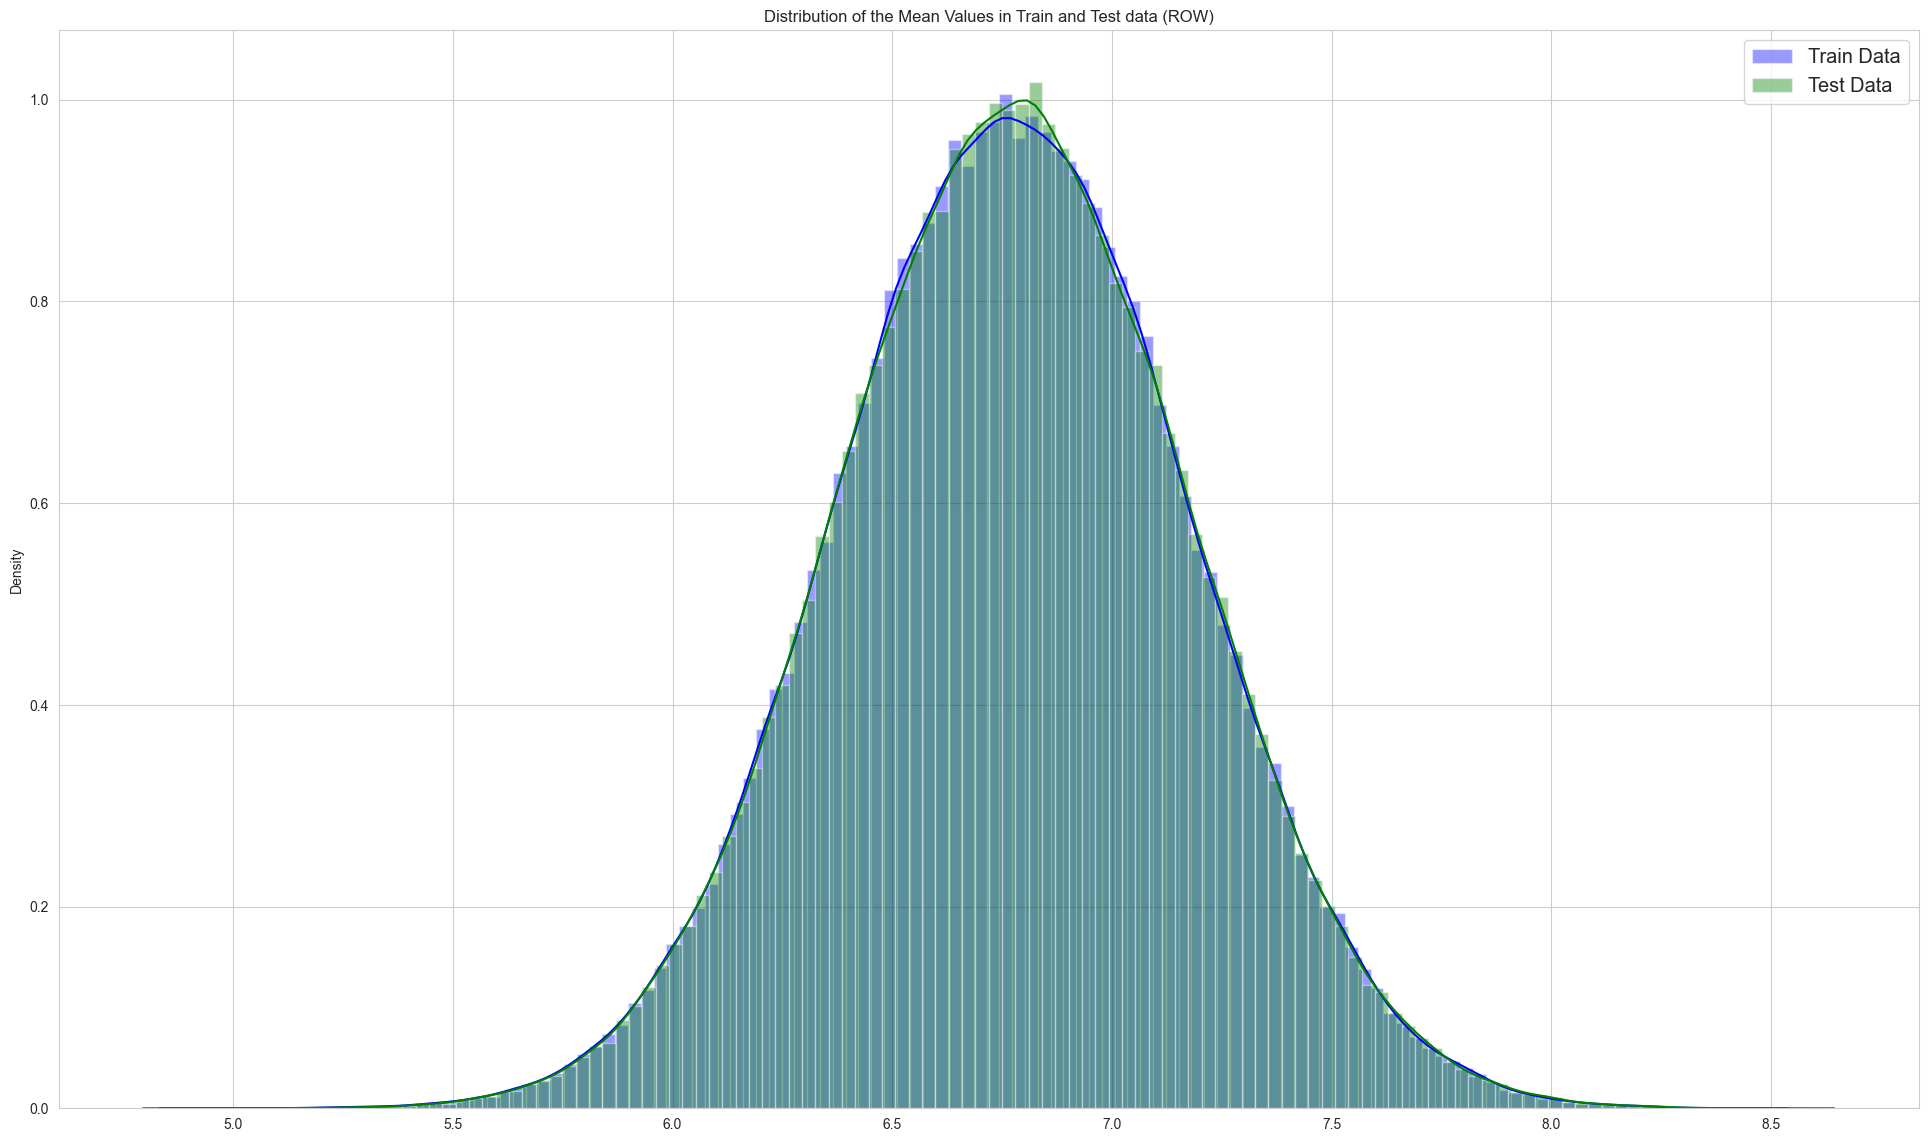

In [34]:
plotting_mean_distribution(train_data, test_data, features)
plotting_mean_row_distribution(train_data, test_data, features)

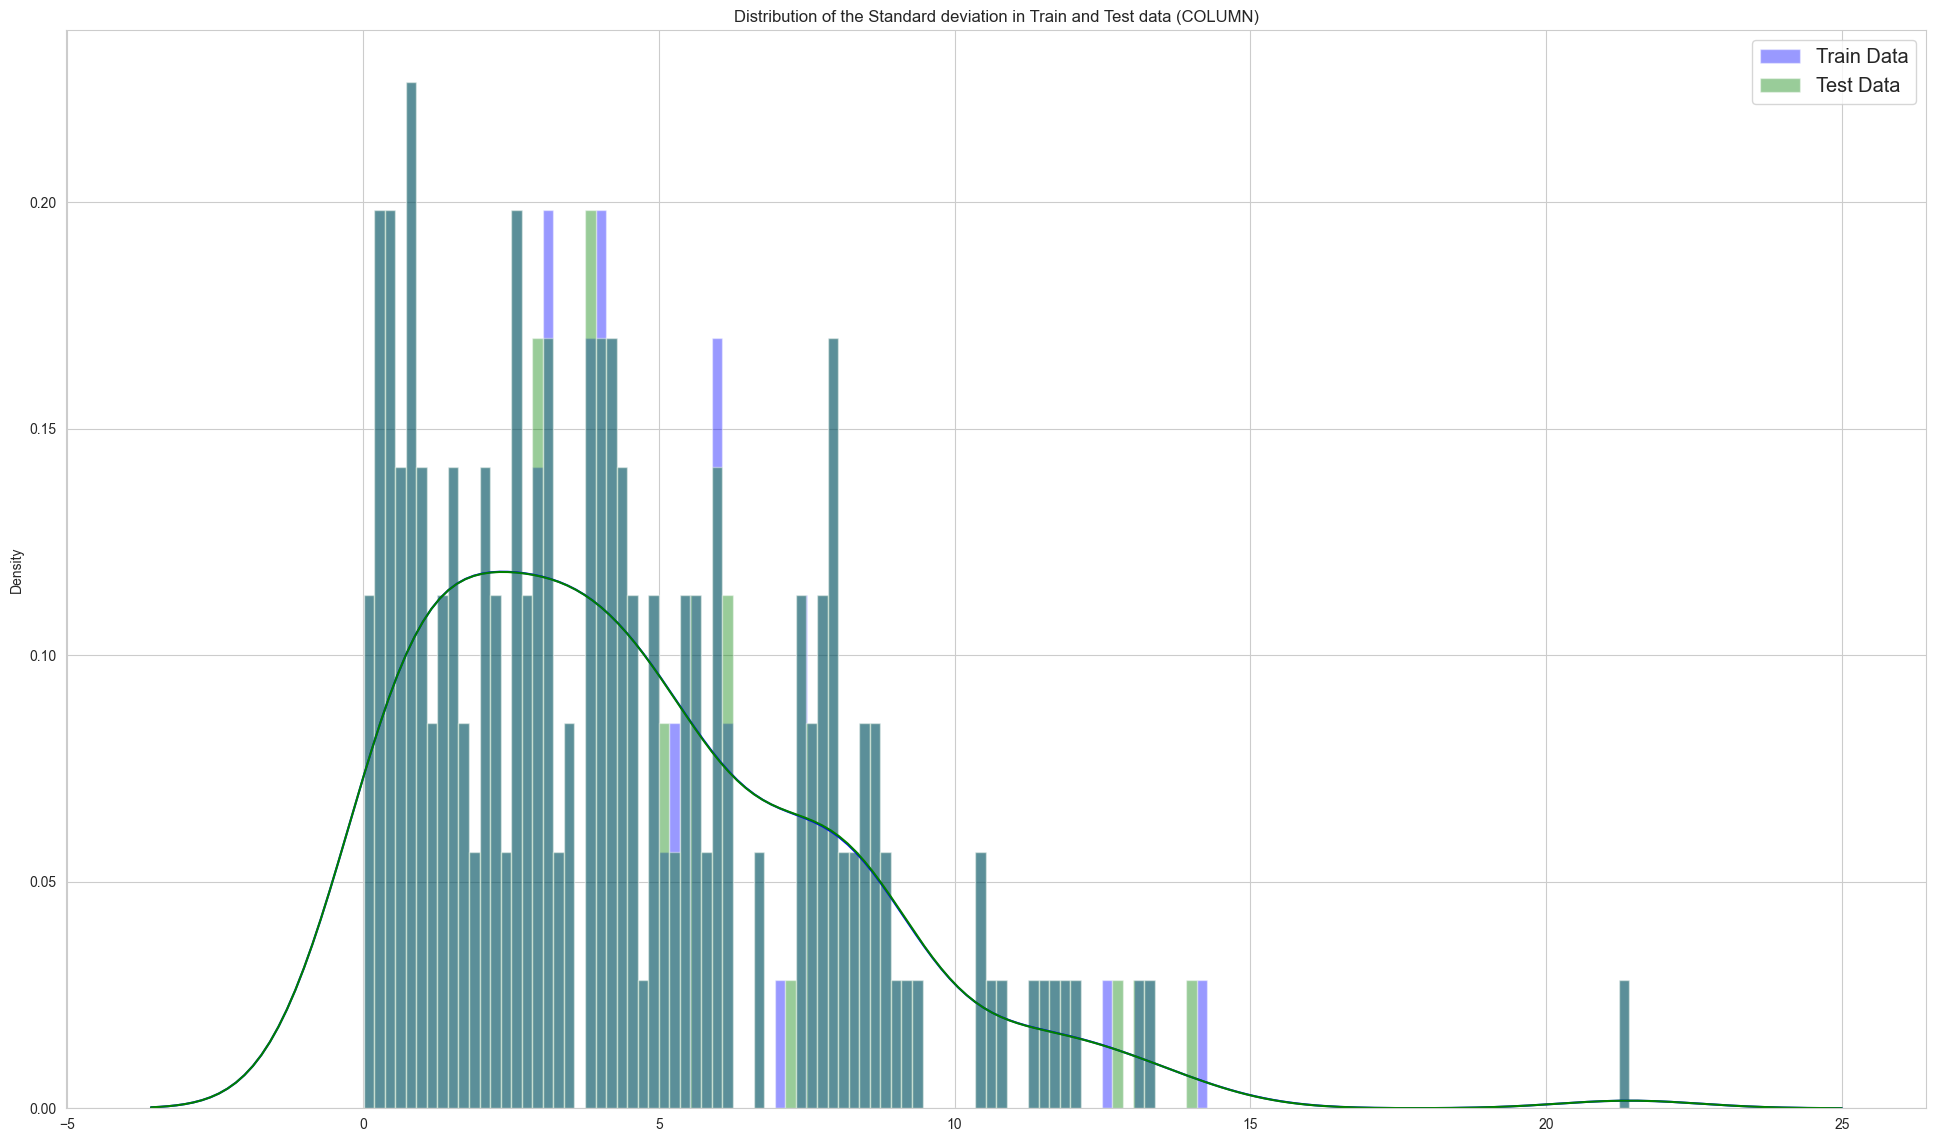

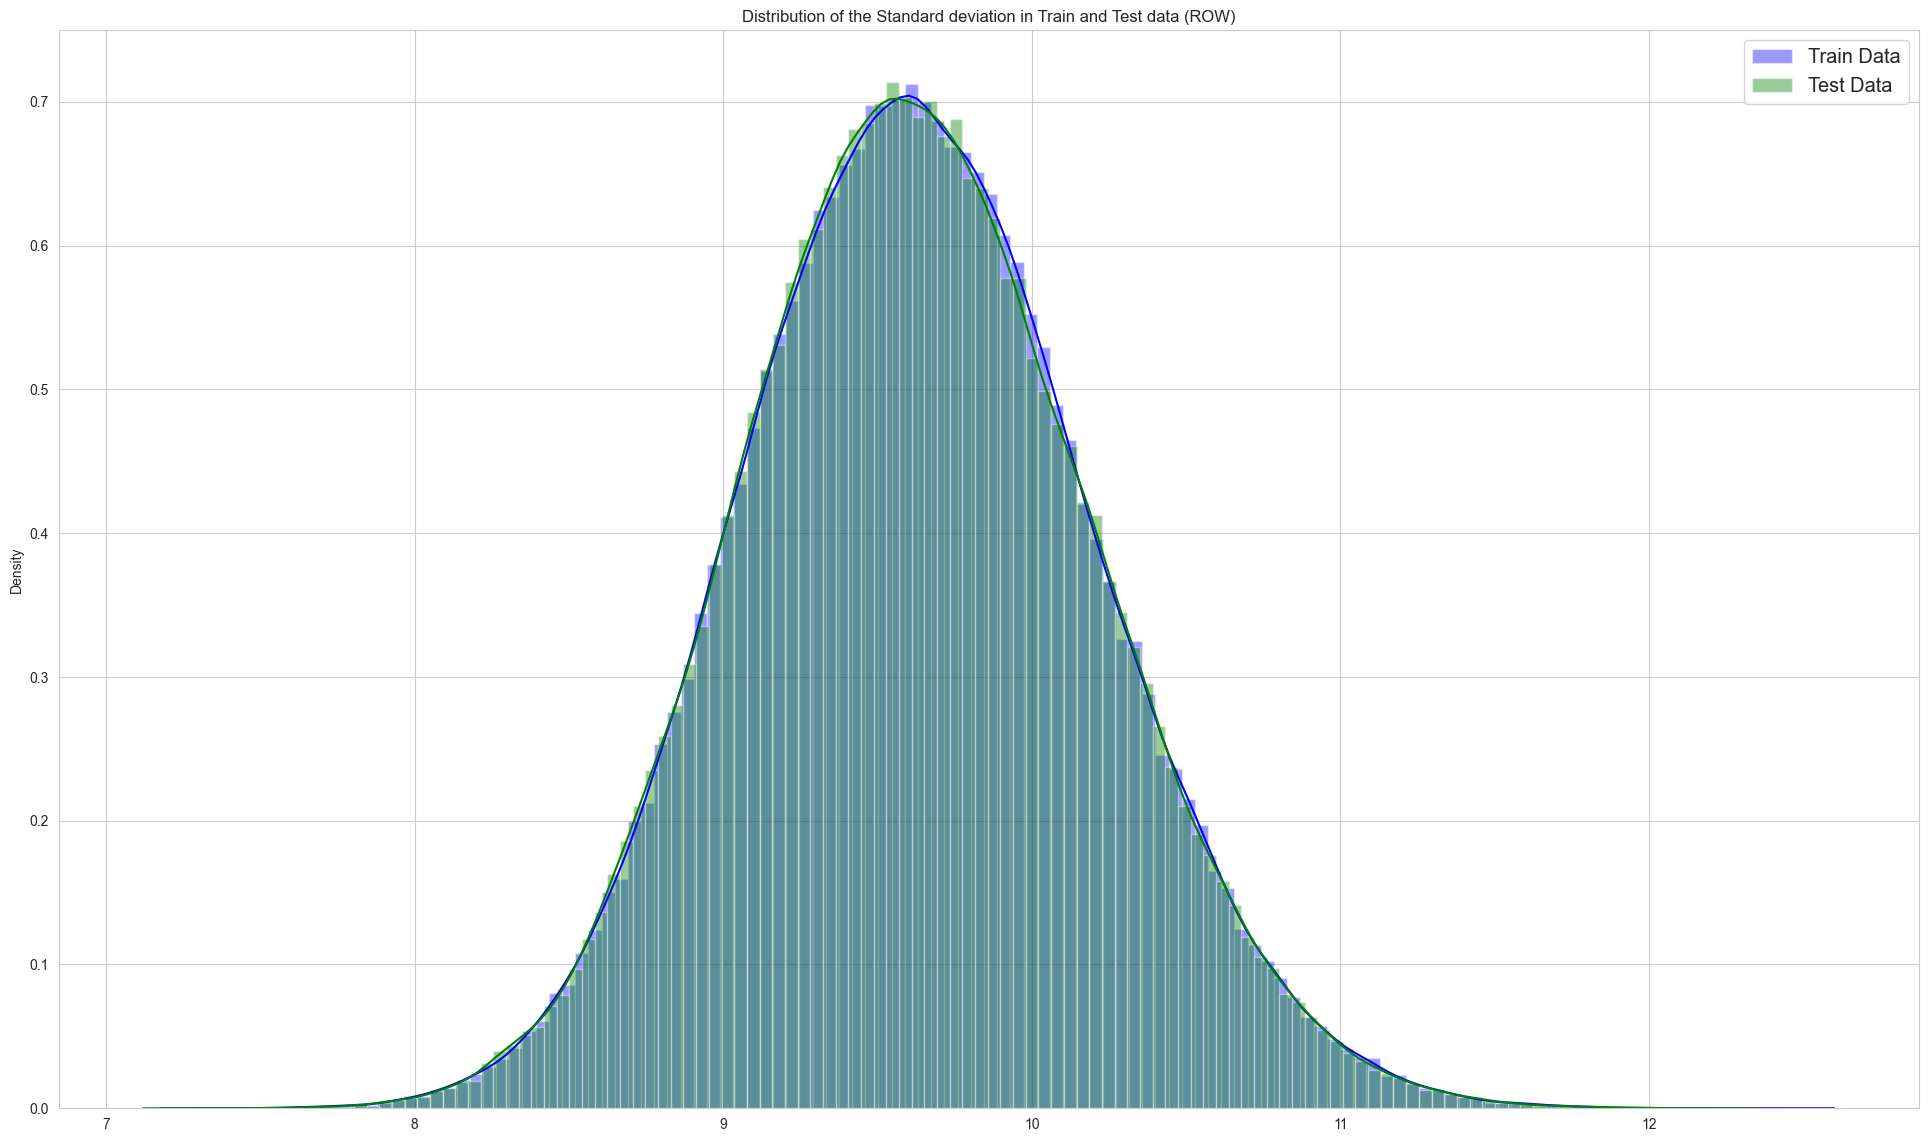

In [35]:
plotting_std_distribution(train_data, test_data, features)
plotting_std_row_distribution(train_data, test_data, features)

**When we observe a low profile of each feature in training and testing, they have very close distribution. But looking at it in a very general way, they are not the same. 
The curves above shows us the maximum, minimum, mean and standard deviation values of the distribution in the training and test data.**

Note: In this dataset, the bank needs to predict whether customers will make any specific transactions in the future, regardless of the money transacted. My guess, is that there may be a set of transactions that they want to monitor or something like that, but it is not possible to know why they have negative or positive data, and what they mean. And we must predict whether the customer will carry out this transaction in the future again or not, given his previous transactions.

#### Feature Engineering/Selection
---

Feature Engineering Process: 
- Brainstorming features to create;
- Checking how the features work with your model;
- Improving your features if needed;
- Create more features until the work is done;

In this case, it is difficult to decide, for example, which features to put together to generate a new feature, the data is very obscure and we do not have the name of the features. So there is no point in making this interaction since the number of features is very huge. I also don't see an option to group feature types or perform feature encoding. 

At this point I will not make a features selection, because the nature of the data does not give me much confidence that it will be a good choice at the moment. But for the model that I will use, [**Gini Index**](https://pythonhosted.org/ibmdbpy/feature_selection.html#gini-index) I believe it would be a good choice, if the data were not so obscure.

#### Light Gradient Boosting Machine
---
The model I chose to train this data was LightGBM is a distributed and efficient gradient boosting framework that uses tree-based learning. 

- Faster training speed and higher efficiency
- Lowe memory usage
- Better accuracy
- Handles missing values
- Support of parallel and GPU Learning
- Capable of handling large-scale data
- Handles regression and classification problems
- Works for imbalanced data by setting is_unbalance=false


In [42]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
features = [c for c in train_data.columns if c not in ["ID_code", "target"]]
target = train_data["target"]

param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [48]:
oof = np.zeros(len(train_data))
predictions = np.zeros(len(test_data))

#saving runs in mlflow for autologging 
mlflow.autolog()

# Generate train and validation set indices to iterate on train values and target values.
for counter_, (trn_idx, val_idx) in enumerate(folds.split(train_data.values, target.values)):
    print("Fold {}".format(counter_))
    
    train = lgb.Dataset(train_data.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val = lgb.Dataset(train_data.iloc[val_idx][features], label=target.iloc[val_idx])
    
    #model classifier
    classifier = lgb.train(param, train, 1000000, valid_sets = [train, val],callbacks=[lgb.early_stopping(stopping_rounds=80), lgb.log_evaluation(50)])
    
    oof[val_idx] = classifier.predict(train_data.iloc[val_idx][features], num_iteration=classifier.best_iteration)
    predictions += classifier.predict(test_data[features], num_iteration=classifier.best_iteration) / folds.n_splits
    autolog_run = mlflow.last_active_run()
    print(autolog_run)



2024/04/29 08:01:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/04/29 08:01:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2024/04/29 08:01:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.


Fold 0


2024/04/29 08:01:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '55491adea1f34252a7637aebcb57e327', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


[LightGBM] [Info] Number of positive: 18089, number of negative: 161911
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 200
Training until validation scores don't improve for 80 rounds
[50]	training's auc: 0.829138	valid_1's auc: 0.815318
[100]	training's auc: 0.84586	valid_1's auc: 0.834851
[150]	training's auc: 0.852066	valid_1's auc: 0.842311
[200]	training's auc: 0.853666	valid_1's auc: 0.845346
[250]	training's auc: 0.859514	valid_1's auc: 0.851393
[300]	training's auc: 0.863887	valid_1's auc: 0.855191
[350]	training's auc: 0.86819	valid_1's auc: 0.857924
[400]	training's auc: 0.869476	valid_1's auc: 0.85964
[450]	training's auc: 0.8706	valid_1's auc: 0.860297
[500]	training's auc: 

2024/04/29 08:03:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: [Errno 13] Permission denied: 'C:\\Users\\91886\\OneDrive\\Desktop\\MLOPs-Santander-Dataset\\Model Development\\mlruns\\0\\55491adea1f34252a7637aebcb57e327\\metrics\\training-auc'
2024/04/29 08:03:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: [Errno 13] Permission denied: 'C:\\Users\\91886\\OneDrive\\Desktop\\MLOPs-Santander-Dataset\\Model Development\\mlruns\\0\\55491adea1f34252a7637aebcb57e327\\metrics\\valid_1-auc'


[950]	training's auc: 0.885512	valid_1's auc: 0.87237
[1000]	training's auc: 0.886729	valid_1's auc: 0.873486
[1050]	training's auc: 0.88819	valid_1's auc: 0.874439


2024/04/29 08:03:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: [Errno 13] Permission denied: 'C:\\Users\\91886\\OneDrive\\Desktop\\MLOPs-Santander-Dataset\\Model Development\\mlruns\\0\\55491adea1f34252a7637aebcb57e327\\metrics\\valid_1-auc'


[1100]	training's auc: 0.889354	valid_1's auc: 0.87526
[1150]	training's auc: 0.890601	valid_1's auc: 0.876291
[1200]	training's auc: 0.891768	valid_1's auc: 0.877356
[1250]	training's auc: 0.892754	valid_1's auc: 0.878116
[1300]	training's auc: 0.893883	valid_1's auc: 0.879204
[1350]	training's auc: 0.894651	valid_1's auc: 0.879699
[1400]	training's auc: 0.895748	valid_1's auc: 0.880599
[1450]	training's auc: 0.896766	valid_1's auc: 0.881355
[1500]	training's auc: 0.897804	valid_1's auc: 0.882157
[1550]	training's auc: 0.898681	valid_1's auc: 0.882736
[1600]	training's auc: 0.899507	valid_1's auc: 0.883439
[1650]	training's auc: 0.900179	valid_1's auc: 0.883946
[1700]	training's auc: 0.901028	valid_1's auc: 0.884765
[1750]	training's auc: 0.901637	valid_1's auc: 0.885361
[1800]	training's auc: 0.902408	valid_1's auc: 0.886055
[1850]	training's auc: 0.90321	valid_1's auc: 0.886602
[1900]	training's auc: 0.904114	valid_1's auc: 0.887058
[1950]	training's auc: 0.90477	valid_1's auc: 0.88

2024/04/29 08:04:18 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\91886\AppData\Local\Temp\tmp08pvoyn4\model, flavor: lightgbm). Fall back to return ['lightgbm==4.3.0']. Set logging level to DEBUG to see the full traceback. 


<Run: data=<RunData: metrics={'best_iteration': 4738.0,
 'stopped_iteration': 4815.0,
 'training-auc': 0.9274641126117981,
 'valid_1-auc': 0.8990515665996264}, params={'bagging_fraction': '0.4',
 'bagging_freq': '5',
 'boost': 'gbdt',
 'boost_from_average': 'false',
 'categorical_feature': 'auto',
 'feature_fraction': '0.05',
 'feature_name': 'auto',
 'keep_training_booster': 'False',
 'learning_rate': '0.01',
 'max_depth': '-1',
 'metric': 'auc',
 'min_data_in_leaf': '80',
 'min_sum_hessian_in_leaf': '10.0',
 'num_boost_round': '1000000',
 'num_leaves': '13',
 'num_threads': '8',
 'objective': 'binary',
 'tree_learner': 'serial',
 'verbosity': '1'}, tags={'mlflow.autologging': 'lightgbm',
 'mlflow.log-model.history': '[{"run_id": "55491adea1f34252a7637aebcb57e327", '
                             '"artifact_path": "model", "utc_time_created": '
                             '"2024-04-29 02:34:14.841872", "flavors": '
                             '{"python_function": {"loader_module": '


2024/04/29 08:04:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '29a9d7ec10694528bd73cd98f7ea2d21', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


[LightGBM] [Info] Number of positive: 18089, number of negative: 161911
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 200
Training until validation scores don't improve for 80 rounds
[50]	training's auc: 0.8297	valid_1's auc: 0.808565
[100]	training's auc: 0.847111	valid_1's auc: 0.824246
[150]	training's auc: 0.853235	valid_1's auc: 0.831647
[200]	training's auc: 0.85551	valid_1's auc: 0.835949
[250]	training's auc: 0.860186	valid_1's auc: 0.840845
[300]	training's auc: 0.864665	valid_1's auc: 0.845284
[350]	training's auc: 0.868795	valid_1's auc: 0.849807
[400]	training's auc: 0.870116	valid_1's auc: 0.851451
[450]	training's auc: 0.871096	valid_1's auc: 0.852291
[500]	training's auc: 0.873343	valid_1's auc: 0.854118
[550]	training's auc: 0.87423

2024/04/29 08:06:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: [Errno 13] Permission denied: 'C:\\Users\\91886\\OneDrive\\Desktop\\MLOPs-Santander-Dataset\\Model Development\\mlruns\\0\\29a9d7ec10694528bd73cd98f7ea2d21\\metrics\\training-auc'
2024/04/29 08:06:00 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: [Errno 13] Permission denied: 'C:\\Users\\91886\\OneDrive\\Desktop\\MLOPs-Santander-Dataset\\Model Development\\mlruns\\0\\29a9d7ec10694528bd73cd98f7ea2d21\\metrics\\valid_1-auc'


[650]	training's auc: 0.877434	valid_1's auc: 0.85746
[700]	training's auc: 0.87987	valid_1's auc: 0.859919
[750]	training's auc: 0.880412	valid_1's auc: 0.859959
[800]	training's auc: 0.881942	valid_1's auc: 0.861832
[850]	training's auc: 0.883006	valid_1's auc: 0.862708
[900]	training's auc: 0.884338	valid_1's auc: 0.86398
[950]	training's auc: 0.885547	valid_1's auc: 0.864841
[1000]	training's auc: 0.886728	valid_1's auc: 0.865748
[1050]	training's auc: 0.888164	valid_1's auc: 0.867267
[1100]	training's auc: 0.889388	valid_1's auc: 0.868351
[1150]	training's auc: 0.890724	valid_1's auc: 0.869812
[1200]	training's auc: 0.89189	valid_1's auc: 0.870824
[1250]	training's auc: 0.892876	valid_1's auc: 0.87175
[1300]	training's auc: 0.89406	valid_1's auc: 0.872598
[1350]	training's auc: 0.894734	valid_1's auc: 0.873249
[1400]	training's auc: 0.895759	valid_1's auc: 0.874396
[1450]	training's auc: 0.896775	valid_1's auc: 0.875308
[1500]	training's auc: 0.897691	valid_1's auc: 0.876044
[1550

2024/04/29 08:07:23 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\91886\AppData\Local\Temp\tmpe5528grj\model, flavor: lightgbm). Fall back to return ['lightgbm==4.3.0']. Set logging level to DEBUG to see the full traceback. 


<Run: data=<RunData: metrics={'best_iteration': 6719.0,
 'stopped_iteration': 6797.0,
 'training-auc': 0.9366179940805879,
 'valid_1-auc': 0.8976839783201152}, params={'bagging_fraction': '0.4',
 'bagging_freq': '5',
 'boost': 'gbdt',
 'boost_from_average': 'false',
 'categorical_feature': 'auto',
 'feature_fraction': '0.05',
 'feature_name': 'auto',
 'keep_training_booster': 'False',
 'learning_rate': '0.01',
 'max_depth': '-1',
 'metric': 'auc',
 'min_data_in_leaf': '80',
 'min_sum_hessian_in_leaf': '10.0',
 'num_boost_round': '1000000',
 'num_leaves': '13',
 'num_threads': '8',
 'objective': 'binary',
 'tree_learner': 'serial',
 'verbosity': '1'}, tags={'mlflow.autologging': 'lightgbm',
 'mlflow.log-model.history': '[{"run_id": "29a9d7ec10694528bd73cd98f7ea2d21", '
                             '"artifact_path": "model", "utc_time_created": '
                             '"2024-04-29 02:37:20.961311", "flavors": '
                             '{"python_function": {"loader_module": '


2024/04/29 08:07:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd76d46308f984b519ca84f1249f959a7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


[LightGBM] [Info] Number of positive: 18088, number of negative: 161912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 200
Training until validation scores don't improve for 80 rounds
[50]	training's auc: 0.831146	valid_1's auc: 0.825062
[100]	training's auc: 0.845068	valid_1's auc: 0.838351
[150]	training's auc: 0.851094	valid_1's auc: 0.845292
[200]	training's auc: 0.85386	valid_1's auc: 0.847559
[250]	training's auc: 0.859335	valid_1's auc: 0.853421
[300]	training's auc: 0.863477	valid_1's auc: 0.85751
[350]	training's auc: 0.867583	valid_1's auc: 0.861643
[400]	training's auc: 0.869398	valid_1's auc: 0.862552
[450]	training's auc: 0.870222	valid_1's auc: 0.864214
[500]	training's auc: 0.872455	valid_1's auc: 0.865684


2024/04/29 08:09:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: [Errno 13] Permission denied: 'C:\\Users\\91886\\OneDrive\\Desktop\\MLOPs-Santander-Dataset\\Model Development\\mlruns\\0\\d76d46308f984b519ca84f1249f959a7\\metrics\\valid_1-auc'


[550]	training's auc: 0.873642	valid_1's auc: 0.866325
[600]	training's auc: 0.875614	valid_1's auc: 0.868612
[650]	training's auc: 0.877301	valid_1's auc: 0.870168
[700]	training's auc: 0.879656	valid_1's auc: 0.871665
[750]	training's auc: 0.880399	valid_1's auc: 0.872278
[800]	training's auc: 0.881977	valid_1's auc: 0.873481
[850]	training's auc: 0.882963	valid_1's auc: 0.874157
[900]	training's auc: 0.884272	valid_1's auc: 0.875148
[950]	training's auc: 0.885453	valid_1's auc: 0.876024
[1000]	training's auc: 0.886642	valid_1's auc: 0.877048
[1050]	training's auc: 0.887983	valid_1's auc: 0.878122
[1100]	training's auc: 0.88926	valid_1's auc: 0.879419
[1150]	training's auc: 0.890515	valid_1's auc: 0.88037
[1200]	training's auc: 0.891514	valid_1's auc: 0.881133
[1250]	training's auc: 0.892533	valid_1's auc: 0.881925
[1300]	training's auc: 0.893784	valid_1's auc: 0.8828
[1350]	training's auc: 0.89452	valid_1's auc: 0.883168
[1400]	training's auc: 0.895479	valid_1's auc: 0.883904
[1450]

2024/04/29 08:10:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0c896a632ccc47d6a736411acfc48158', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


[LightGBM] [Info] Number of positive: 18088, number of negative: 161912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 200
Training until validation scores don't improve for 80 rounds
[50]	training's auc: 0.831814	valid_1's auc: 0.819629
[100]	training's auc: 0.847385	valid_1's auc: 0.837052
[150]	training's auc: 0.852512	valid_1's auc: 0.840543
[200]	training's auc: 0.854656	valid_1's auc: 0.84194
[250]	training's auc: 0.859399	valid_1's auc: 0.846709
[300]	training's auc: 0.863574	valid_1's auc: 0.850422
[350]	training's auc: 0.867184	valid_1's auc: 0.8546
[400]	training's auc: 0.869561	valid_1's auc: 0.856114
[450]	training's auc: 0.870352	valid_1's auc: 0.856717
[500]	training's auc: 0.872669	valid_1's auc: 0.858593
[550]	training's auc: 0.87372

2024/04/29 08:14:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4078bd7e295c4feb8b7620c88eaa9bb4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


[LightGBM] [Info] Number of positive: 18088, number of negative: 161912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 200
Training until validation scores don't improve for 80 rounds
[50]	training's auc: 0.832798	valid_1's auc: 0.808509
[100]	training's auc: 0.849139	valid_1's auc: 0.821008
[150]	training's auc: 0.854511	valid_1's auc: 0.82743
[200]	training's auc: 0.85621	valid_1's auc: 0.829855
[250]	training's auc: 0.861383	valid_1's auc: 0.83573
[300]	training's auc: 0.86583	valid_1's auc: 0.839531
[350]	training's auc: 0.869489	valid_1's auc: 0.844274
[400]	training's auc: 0.871453	valid_1's auc: 0.846404
[450]	training's auc: 0.872475	valid_1's auc: 0.846805
[500]	training's auc: 0.874456	valid_1's auc: 0.848751
[550]	training's auc: 0.87548	

2024/04/29 08:15:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: [Errno 13] Permission denied: 'C:\\Users\\91886\\OneDrive\\Desktop\\MLOPs-Santander-Dataset\\Model Development\\mlruns\\0\\4078bd7e295c4feb8b7620c88eaa9bb4\\metrics\\training-auc'


[650]	training's auc: 0.878865	valid_1's auc: 0.852499


2024/04/29 08:15:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: [Errno 13] Permission denied: 'C:\\Users\\91886\\OneDrive\\Desktop\\MLOPs-Santander-Dataset\\Model Development\\mlruns\\0\\4078bd7e295c4feb8b7620c88eaa9bb4\\metrics\\valid_1-auc'


[700]	training's auc: 0.881311	valid_1's auc: 0.855042
[750]	training's auc: 0.881933	valid_1's auc: 0.855446
[800]	training's auc: 0.883575	valid_1's auc: 0.857009
[850]	training's auc: 0.884531	valid_1's auc: 0.857628
[900]	training's auc: 0.885805	valid_1's auc: 0.859191
[950]	training's auc: 0.886907	valid_1's auc: 0.860398
[1000]	training's auc: 0.888051	valid_1's auc: 0.861519
[1050]	training's auc: 0.889379	valid_1's auc: 0.862782
[1100]	training's auc: 0.890572	valid_1's auc: 0.863655
[1150]	training's auc: 0.891835	valid_1's auc: 0.864627
[1200]	training's auc: 0.892806	valid_1's auc: 0.86545
[1250]	training's auc: 0.893756	valid_1's auc: 0.866281
[1300]	training's auc: 0.894937	valid_1's auc: 0.86732
[1350]	training's auc: 0.895596	valid_1's auc: 0.86773
[1400]	training's auc: 0.896654	valid_1's auc: 0.868586
[1450]	training's auc: 0.897681	valid_1's auc: 0.869374
[1500]	training's auc: 0.89873	valid_1's auc: 0.870353
[1550]	training's auc: 0.899555	valid_1's auc: 0.870867
[1

2024/04/29 08:17:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0fbe01412dd4496c96a41b3d797e849b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


[LightGBM] [Info] Number of positive: 18088, number of negative: 161912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 200
Training until validation scores don't improve for 80 rounds
[50]	training's auc: 0.830543	valid_1's auc: 0.812425
[100]	training's auc: 0.846033	valid_1's auc: 0.826252
[150]	training's auc: 0.852584	valid_1's auc: 0.832567
[200]	training's auc: 0.854744	valid_1's auc: 0.835315
[250]	training's auc: 0.859577	valid_1's auc: 0.839122
[300]	training's auc: 0.864057	valid_1's auc: 0.843717
[350]	training's auc: 0.868035	valid_1's auc: 0.848158
[400]	training's auc: 0.86971	valid_1's auc: 0.849037
[450]	training's auc: 0.870911	valid_1's auc: 0.849946
[500]	training's auc: 0.87326	valid_1's auc: 0.853045
[550]	training's auc: 0.8741

2024/04/29 08:21:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b1295b3b09394cbb9493363c3fb10c4f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


[LightGBM] [Info] Number of positive: 18088, number of negative: 161912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 200
Training until validation scores don't improve for 80 rounds
[50]	training's auc: 0.830407	valid_1's auc: 0.82675
[100]	training's auc: 0.845379	valid_1's auc: 0.840748
[150]	training's auc: 0.851829	valid_1's auc: 0.847848
[200]	training's auc: 0.854223	valid_1's auc: 0.846711
[250]	training's auc: 0.859263	valid_1's auc: 0.852155
[300]	training's auc: 0.863823	valid_1's auc: 0.85536
[350]	training's auc: 0.867389	valid_1's auc: 0.858249
[400]	training's auc: 0.868971	valid_1's auc: 0.860384
[450]	training's auc: 0.870394	valid_1's auc: 0.860972
[500]	training's auc: 0.872621	valid_1's auc: 0.862963
[550]	training's auc: 0.8738

2024/04/29 08:24:19 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c18676e4d26044da8620742a0735b67f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


[LightGBM] [Info] Number of positive: 18088, number of negative: 161912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 200
Training until validation scores don't improve for 80 rounds
[50]	training's auc: 0.831417	valid_1's auc: 0.815169
[100]	training's auc: 0.84601	valid_1's auc: 0.833417
[150]	training's auc: 0.851567	valid_1's auc: 0.838036
[200]	training's auc: 0.854101	valid_1's auc: 0.841372
[250]	training's auc: 0.858916	valid_1's auc: 0.845134
[300]	training's auc: 0.863726	valid_1's auc: 0.849354
[350]	training's auc: 0.867838	valid_1's auc: 0.853119
[400]	training's auc: 0.869242	valid_1's auc: 0.853539
[450]	training's auc: 0.870266	valid_1's auc: 0.854423
[500]	training's auc: 0.87273	valid_1's auc: 0.856724
[550]	training's auc: 0.8739

2024/04/29 08:27:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '39dcd6bfe9f4445888b2459f6c7b83fb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


[LightGBM] [Info] Number of positive: 18088, number of negative: 161912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 200
Training until validation scores don't improve for 80 rounds
[50]	training's auc: 0.830369	valid_1's auc: 0.825304
[100]	training's auc: 0.846944	valid_1's auc: 0.837926
[150]	training's auc: 0.853256	valid_1's auc: 0.845808
[200]	training's auc: 0.854863	valid_1's auc: 0.845785
[250]	training's auc: 0.85953	valid_1's auc: 0.84908
[300]	training's auc: 0.863866	valid_1's auc: 0.853514
[350]	training's auc: 0.867892	valid_1's auc: 0.858297
[400]	training's auc: 0.86965	valid_1's auc: 0.860118
[450]	training's auc: 0.870767	valid_1's auc: 0.861472
[500]	training's auc: 0.873237	valid_1's auc: 0.863604
[550]	training's auc: 0.87409

2024/04/29 08:30:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3f736ed82ea04167b17a309813a8e754', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


[LightGBM] [Info] Number of positive: 18088, number of negative: 161912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 200
Training until validation scores don't improve for 80 rounds
[50]	training's auc: 0.829258	valid_1's auc: 0.810972
[100]	training's auc: 0.846388	valid_1's auc: 0.829446
[150]	training's auc: 0.852125	valid_1's auc: 0.833475
[200]	training's auc: 0.854686	valid_1's auc: 0.834998
[250]	training's auc: 0.859942	valid_1's auc: 0.840513
[300]	training's auc: 0.864099	valid_1's auc: 0.845058
[350]	training's auc: 0.86826	valid_1's auc: 0.849246
[400]	training's auc: 0.870171	valid_1's auc: 0.850813
[450]	training's auc: 0.87094	valid_1's auc: 0.851561
[500]	training's auc: 0.873198	valid_1's auc: 0.853768
[550]	training's auc: 0.8742

#### Model training Experimentation
---

With training the model I did fail a couple of times and it was recorded in the mlruns folder under 0 as I have been using mlflow I corrected the hyper params did some research as to which one should be considered and finally came to a good set to get good results while reducing training time

#### Evaluation Metric
---

To measure this prediction, I will use the Area under the ROC curve (AUC): Larger the area under the ROC curve, the better our model is! The way to think about this is the following: if we had a model which produced an ROC curve that had a single point at (1,0), the upper left corner, representing a true positive rate of one and a false positive rate of zero, this would be a great model!

The picture[*](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) bellow show how this AUC is defined. Basically, when the threshold = "0" (p = 0), the model predicts "1" for all the data, which means the true positive rate is equal to the false positive rate, is equal to one. When the threshold = "1", the model predicts "0" for all data, which means that both true and false positive rates are "0". If we vary the threshold between these two extremes, we get a series of diferent false positive and true positive rates.

<img src="img/ROC_curves.png" width="500" style="float:left"/>

In [49]:
print("Cross Validation Score: {:<8.5f}".format(roc_auc_score(target, oof)))

Cross Validation Score: 0.89833 


In [ ]:
#false_positive_rate, recall, thresholds

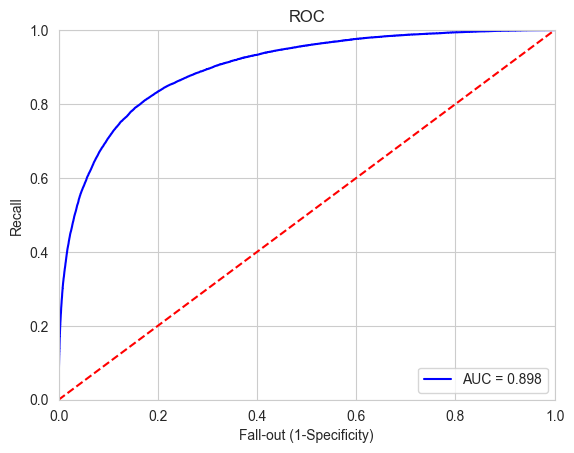

In [50]:
#Print Area Under Curve
plt.figure()

false_positive_rate, recall, thresholds = roc_curve(target, oof)
roc_auc = auc(false_positive_rate, recall)

plt.title('ROC')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

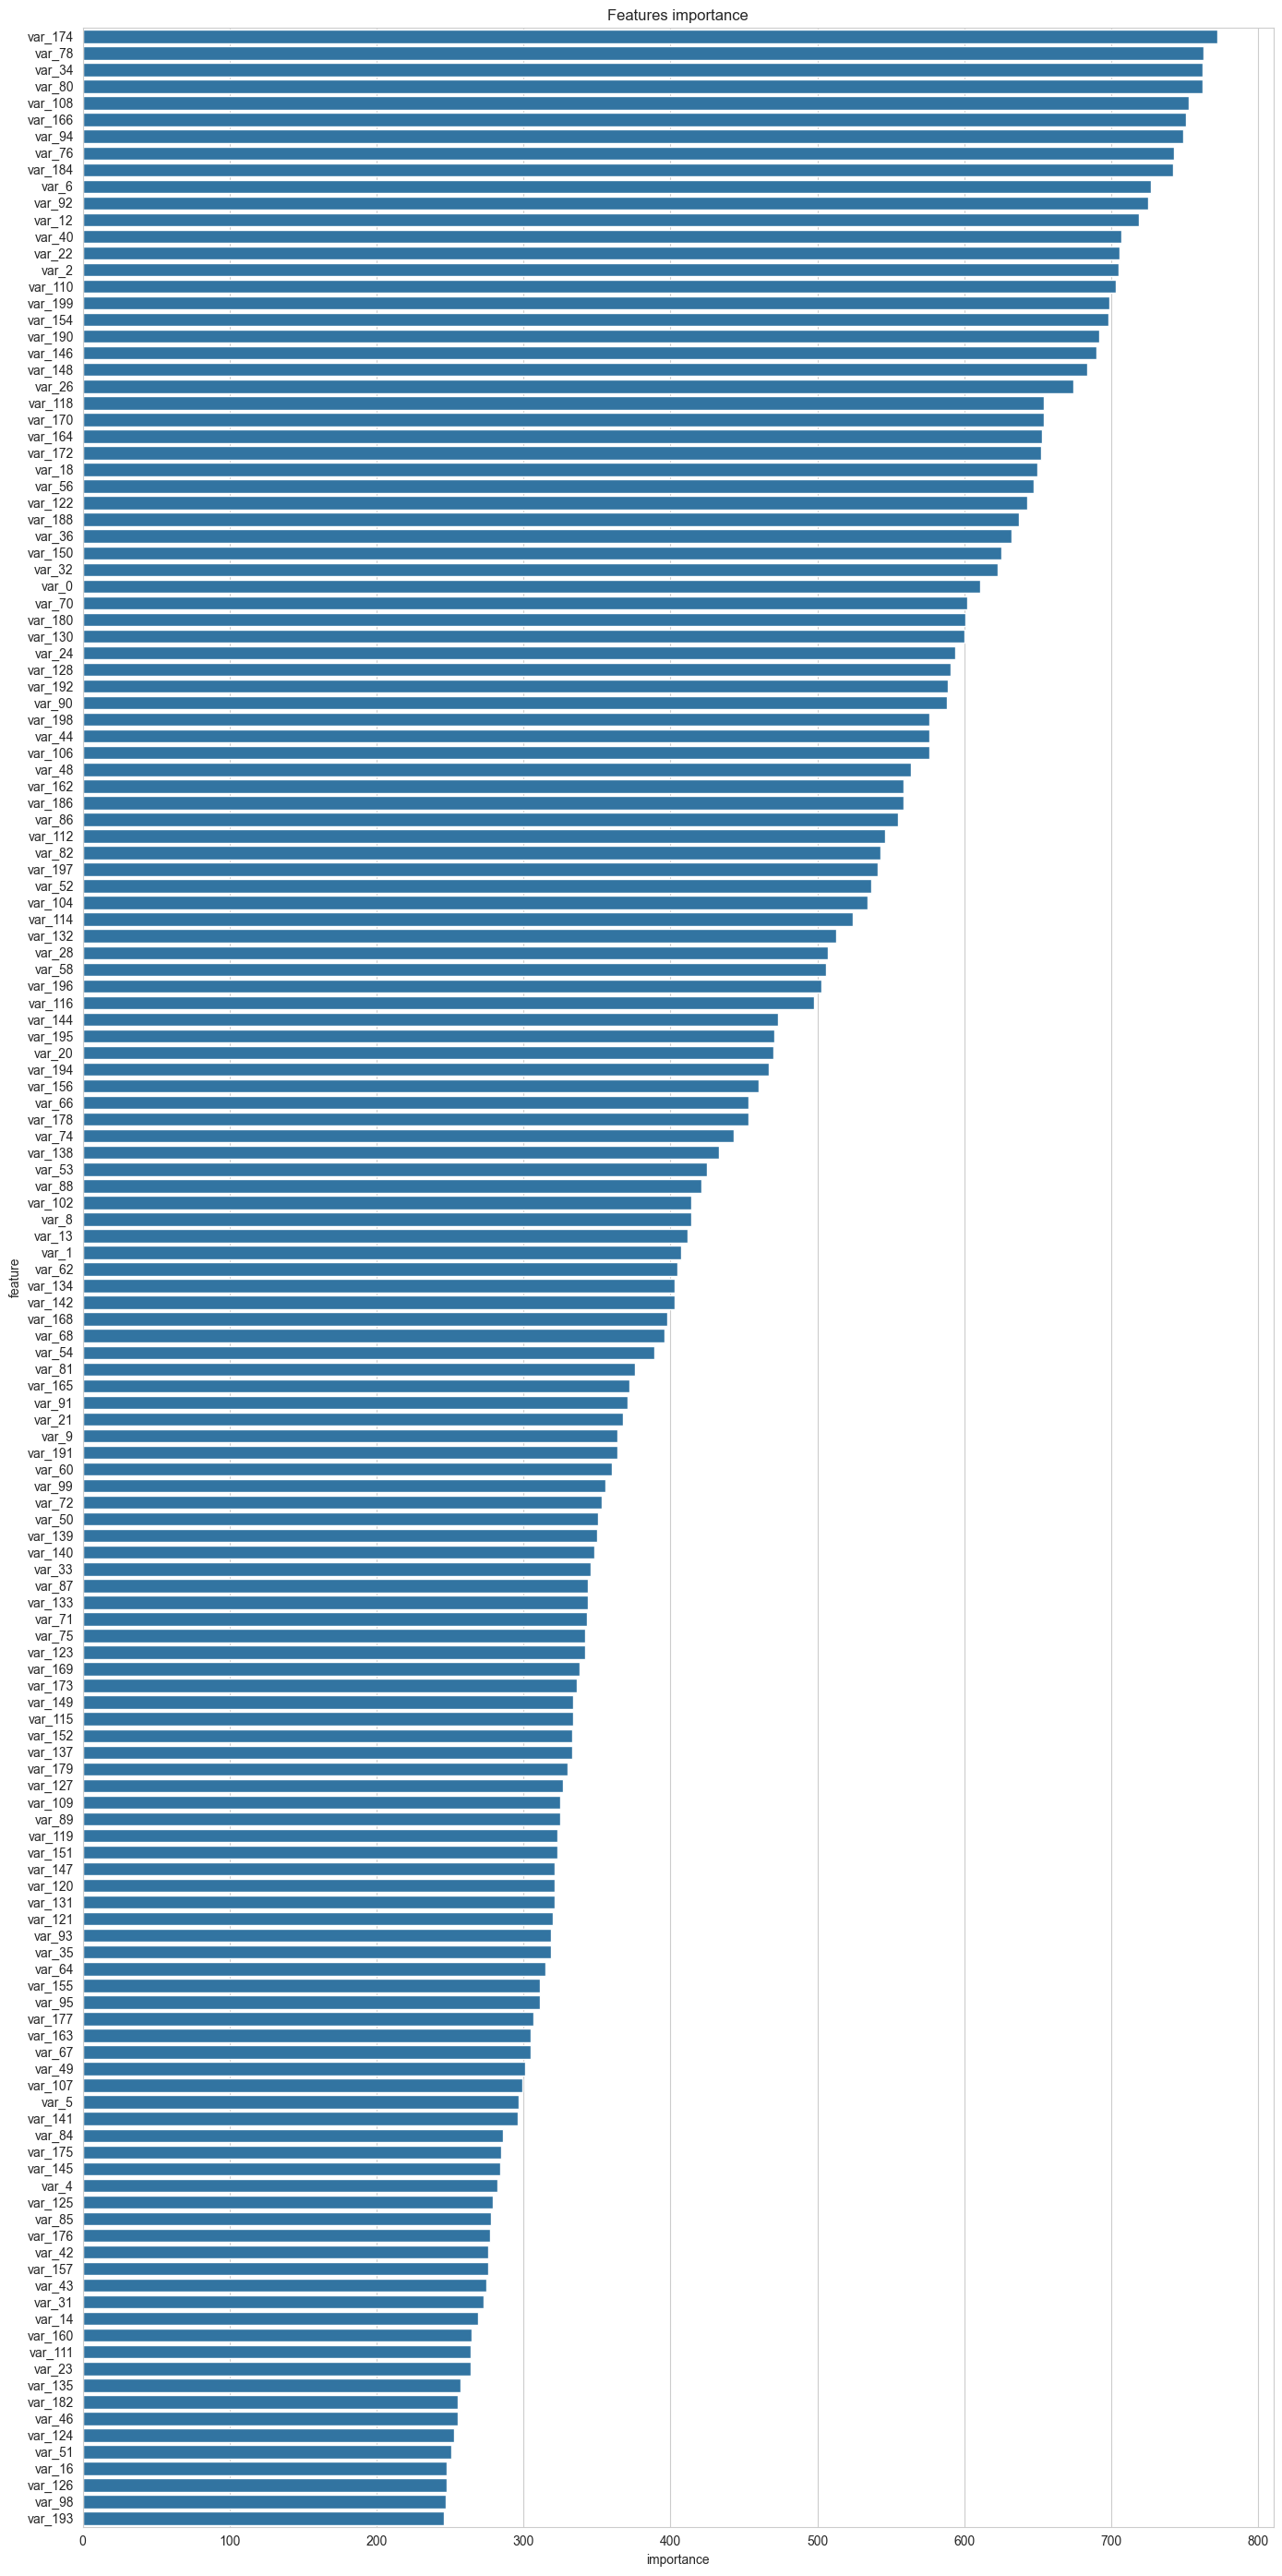

In [51]:
feature_importance = pd.DataFrame()
feature_importance["feature"] = features
feature_importance["importance"] = classifier.feature_importance()

columns = (feature_importance[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)

best_features = feature_importance.loc[feature_importance.feature.isin(columns)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance')
plt.tight_layout()
plt.savefig('featureimportance.png')

In [52]:
#Export LightGBM Model
filename = 'lgbm.pkl'
pickle.dump(classifier, open(filename, 'wb'))